<a href="https://colab.research.google.com/github/OlaKlingberg/Predict-Wildfire-Size/blob/main/Predicting_the_Size_of_U_S_Wildfires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting the Size of U.S. Wildfires**
2024-11-26

GitHub repository: [DTSA-5509-Final-Project-Forest-Fires](https://github.com/OlaKlingberg/DTSA-5509-Final-Project-Forest-Fires)

The starting point for this project is the 2007 paper [A data mining approach to predict forest fires using meteorological data](https://core.ac.uk/works/9801673/) by Paulo Cortez and Aníbal de Jesus Raimundo Morais. The authors try various machine-learning models to predict the size of wildfires in a region of Portugal, based on weather conditions at the time of the fire. Their results are underwhelming: their most succesful model, a Support Vector Machine (SVM) has a better Mean Absolute Error (MAE) than a naive benchmark based on predicting the size of every fire to be the mean of all fires -- but the Root Mean Square Error (RMSE) for that model (and all the other models they evaluate) is actually slightly worse than for the naive benchmark. They conclude that their model has a certain, but fairly weak, predictive power, and that it works best for smaller fires.

In this notebook, I have tried to do something similar, using a dataset of U.S. wildfires from 1992 through 2015. The metereological parameters are not identical to the ones used in the Portuguese study, and the data set excludes very small fires, which is where the Portuguese study had the best results, so it's likely that my results will be different from the ones from that study.

# **Data**
The dataset [U.S. Wildfire data (plus other attributes)](https://www.kaggle.com/datasets/capcloudcoder/us-wildfire-data-plus-other-attributes) contains some 55,000 U.S. wildfires from 1992 to 2015, all of them at least 0.218 hectares (0.54 acres) in size.

One caveat about the data: the dataset was found on Kaggle and does not come directly from authoritative sources. The Kaggle user who put it together writes that the wildfire data comes from the study [Spatial wildfire occurrence data for the United States, 1992-2015](https://www.fs.usda.gov/rds/archive/Catalog/RDS-2013-0009.4/), and the metereological data from [NOAA National Centers for Environmental Information](https://www.ncdc.noaa.gov), but there is scant information about how the data was mined and merged. If I (or someone else) were to keep working on this project, the next step ought to be to retrieve the data directly from the authoritative sources.

# **EDA and Data Cleaning**
The Exploratory Data Analysis will reveal a large number of records without any meteorologial data. As the goal of this study is to make prediction based on meteorogical data, I will omit those records from the analysis.

# **Choosing Predictors**
I will build a preliminary Multiple Regression Model and use stepwise backward elimination to find the predictors that seem most statistically significant.

# **Benchmarks**
Like in the Portuguese study, I will create naive benchmarks by predicting the size of every fire to be the mean of the size of all fires. But I will also create a second benchmark, based on the median rather than the mean size. This second benchmark will turn out to be much more challenging to beat.

# **Models**
I will build four different kinds of models:
* Multiple Logic Regression
* Support Vector Regreession (SVR)
* Random Forests
* Feed-Forward Neural Network

# **Evaluation**
I will compare the best-performing model against my mean- and median-based naive benchmarks, using Mean Absolute Error (MEA), Root Mean Squared Error (RMSE), as well as Mean Absolute Percentage Error (MAPE).

# **Mount Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Installs and Imports**

In [ ]:
# !pip install statsmodels
# !pip install mlxtend

In [ ]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from datetime import datetime
import warnings
from math import e

# Scikit Learn
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, root_mean_squared_error
from sklearn.metrics import accuracy_score, make_scorer, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# Other data-science libraries
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from scipy.stats import f
import statsmodels.api as sm

# TensorFlow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping


# **Exploratory Data Analysis and Data Cleaning**

## **Load the data**

In [ ]:
# Directories

# Directories in the Colab root directory
# MAIN_DIR = '/content/'
# DATA_DIR = os.path.join(MAIN_DIR, 'data')
# GENERATED_FILES_DIR = os.path.join(MAIN_DIR, 'generated_files')

# Directories on my local machine
MAIN_DIR = '/content/drive/MyDrive/Colab/Boulder/20. Introduction to Machine Learning/Module 7. Final Project'
DATA_DIR = os.path.join(MAIN_DIR, 'data')
GENERATED_FILES_DIR = os.path.join(MAIN_DIR, 'generated_files')

In [ ]:
# Read the data
fires = pd.read_csv(os.path.join(DATA_DIR, 'FW_Veg_Rem_Combined.csv'))

# Shuffle the rows (may or may not be necessary)
fires = fires.sample(frac = 1)

## **Dimensions of the data**
As seen below, the data consists of 55,367 rows (fires) and 43 columns (features). Many of the columns are less relevant for my purpuses, so I will select an initial set of 16:
* **fire_size**. In acres; numerical.
* **disc_clean_data**. Date when the fire was discovered; string in format mm/dd/YYYY.
* **discovery_month**. Month when the fire was discovered; categorical.
* **Vegetation**. Type of vegetation; categorical.
* **Temp_pre_30, Temp_pre_15, Temp_pre_7**. Average temperatures, in Celsius, during the 30, 15, and 7 days preceeding the fire; numerical.
* **Wind_pre_30, Wind_pre_15, Wind_pre_7**. Average windspeeds, in m/s, during these time periods; numerical.
* **Hum_pre_30, Hum_pre_15, Hum_pre_7**. Average relative humidity during these time periods; numerical.
* **Prec_pre_30, Prec_pre_15, Prec_pre_7**. Total precipitation, in mm, during these time periods; numerical.




In [ ]:
# Dimensions
print(f"Number of rows (wildfires): {fires.shape[0]}")
print(f"Number of columns: {fires.shape[1]}")

Number of rows (wildfires): 55367
Number of columns: 43


In [ ]:
fires.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'fire_name', 'fire_size',
       'fire_size_class', 'stat_cause_descr', 'latitude', 'longitude', 'state',
       'disc_clean_date', 'cont_clean_date', 'discovery_month',
       'disc_date_final', 'cont_date_final', 'putout_time', 'disc_date_pre',
       'disc_pre_year', 'disc_pre_month', 'wstation_usaf', 'dstation_m',
       'wstation_wban', 'wstation_byear', 'wstation_eyear', 'Vegetation',
       'fire_mag', 'weather_file', 'Temp_pre_30', 'Temp_pre_15', 'Temp_pre_7',
       'Temp_cont', 'Wind_pre_30', 'Wind_pre_15', 'Wind_pre_7', 'Wind_cont',
       'Hum_pre_30', 'Hum_pre_15', 'Hum_pre_7', 'Hum_cont', 'Prec_pre_30',
       'Prec_pre_15', 'Prec_pre_7', 'Prec_cont', 'remoteness'],
      dtype='object')

In [ ]:
# Select columns to keep
columns = ['fire_size', 'disc_clean_date', 'discovery_month', 'Vegetation', \
           'Temp_pre_30', 'Temp_pre_15', 'Temp_pre_7', \
           'Wind_pre_30', 'Wind_pre_15', 'Wind_pre_7', \
           'Hum_pre_30', 'Hum_pre_15', 'Hum_pre_7', \
           'Prec_pre_30', 'Prec_pre_15', 'Prec_pre_7']

fires = fires[columns]

In [ ]:
fires.dtypes

,0
fire_size,float64
disc_clean_date,object
discovery_month,object
Vegetation,int64
Temp_pre_30,float64
Temp_pre_15,float64
Temp_pre_7,float64
Wind_pre_30,float64
Wind_pre_15,float64
Wind_pre_7,float64


## **Transform features**

I will make these transformations and additions:
* **disc_clean_date:** transform from string to datetime object and rename to **discovery_date**
* Add **fire_size_ha:** Fire size in hectares.
* Add **ln(fire_size_ha)**. The natural log of the fire size (in hectares). For strongly right-skewed data (which we will see that this is), using a log-transform reduces skewness.
* Add **discovery_year**, for convenince.

In [ ]:
# Convert dates from strings to datetime objects
if 'disc_clean_date' in fires.columns: # To avoid error if you happen to rerun the cell
    fires['discovery_date'] = pd.to_datetime(fires['disc_clean_date'])
    fires.drop(columns = ['disc_clean_date'], inplace = True)

In [ ]:
# Convert acres to hectares
fires['fire_size_ha'] = fires['fire_size'] * 0.404686

In [ ]:
# Add a column for the natural log of the fire size
fires['ln(fire_size_ha)'] = np.log(fires['fire_size_ha'])

In [ ]:
# Add a column for discovery year
fires['discovery_year'] = fires['discovery_date'].dt.year

In [ ]:
# Reorder the columns, for easier overview
columns = ['fire_size_ha', 'ln(fire_size_ha)', 'discovery_date', 'discovery_year', 'discovery_month', 'Vegetation', \
           'Temp_pre_30', 'Temp_pre_15', 'Temp_pre_7', \
           'Wind_pre_30', 'Wind_pre_15', 'Wind_pre_7', \
           'Hum_pre_30', 'Hum_pre_15', 'Hum_pre_7', \
           'Prec_pre_30', 'Prec_pre_15', 'Prec_pre_7']

fires = fires[columns]

## **Missing values**

Checking for values that might indicated missing data, we will find that:
* **Null**
 * There are no null values.
* **0**
 * Many columns contain zeros, but most of these are for variables where 0 is a plausible value, such as temperature, wind speed, and precipitation.
 * The one exception is Vegetation, which is a categorical variable, where the levels are numbered, corresponding to different vegetation types. We'll see further down that there is no Vegetation type 0, so I take 0 to mean that information is missing. As almost 18% of the records have a 0 in this column, I will keep these records and treat 0 as its own Vegetation level, meaning simply "unknown".
* **-1**
 * Just over a quarter of the rows, or 14,235 rows, have **–1** in all numerical columns. While **-1** could be a valid value for temperature, it can not be a valid value for wind speed, relative humidity, or total precipitation, indicating that **-1** has been used here to signify missing data. I can think of no reasonable way to impute these numbers from the other data, so I will remove all these records.

In [ ]:
# Check for Null values
fires.isnull().sum()[(fires.isnull().sum() > 0).values]

,0


In [ ]:
# Check for 0s
(fires == 0).sum()[(fires == 0).sum() > 0]

,0
Vegetation,9752
Temp_pre_30,2557
Temp_pre_15,3937
Temp_pre_7,4596
Wind_pre_30,3006
Wind_pre_15,4386
Wind_pre_7,5039
Hum_pre_30,3872
Hum_pre_15,5258
Hum_pre_7,5894


In [ ]:
# Check for -1s?
(fires == -1).sum()[(fires == -1).sum() > 0]

,0
Temp_pre_30,14235
Temp_pre_15,14235
Temp_pre_7,14235
Wind_pre_30,14235
Wind_pre_15,14235
Wind_pre_7,14235
Hum_pre_30,14235
Hum_pre_15,14235
Hum_pre_7,14235
Prec_pre_30,14235


In [ ]:
# Remove rows containing -1s
fires = fires[~fires.isin([-1]).any(axis = 1)]

In [ ]:
# Dimensions of the remaining data
fires.shape

(41132, 18)

## **Distribuition of the numerical features**

When looking at the distribution of the numerical variables, two things stand out:
### Skew of the response variable
The response variable, **fire_size_ha** (fire size in hectares), is extremely right-skewed, as evidenced by the mean being over 500 times larger than the median.

We'll look closer at this skew and how to handle it further down.

### Precipitation max values
The max values in the precipitation columns are surprisingly large, especially:
* **Prec_pre_30**. Max value: 13,561. This is meant to be the total precipitation in the 30 days preceeding the discovery of the fire. Over thirteen *meters* of rain in a month sounds implausible.  According to information found online, the largest amount of precipitation in one month recorded in the U.S. is 3,78 m ([March 1982, Mt. Waialeale on Hawaii's Kauai Island](https://www.wunderground.com/cat6/Summary-US-State-Historical-Precipitation-Extremes)). We will take a closer look at outliers using box plots.




In [ ]:
# Basic distribution metrics for the size of fires
min_fire_size = fires['fire_size_ha'].min()
median_fire_size = fires['fire_size_ha'].median()
mean_fire_size = fires['fire_size_ha'].mean()
max_fire_size = fires['fire_size_ha'].max()

print(f"Min: {min_fire_size:.2f}")
print(f"Median: {median_fire_size:.2f}")
print(f"Mean: {mean_fire_size:.0f}")
print(f"Max: {max_fire_size:.0f}")

print(f"\nThe mean fire size is {mean_fire_size/median_fire_size:.0f} times larger \
than the median fire size, indicating extreme right skew.")


Min: 0.21
Median: 1.62
Mean: 918
Max: 217741

The mean fire size is 567 times larger than the median fire size, indicating extreme right skew.


In [ ]:
# Distribution metrics for the columns 0 - 8.
fires.iloc[:, :9].describe()

,fire_size_ha,ln(fire_size_ha),discovery_date,discovery_year,Vegetation,Temp_pre_30,Temp_pre_15,Temp_pre_7
count,41132.000000,41132.000000,41132,41132.000000,41132.000000,41132.000000,41132.000000,41132.000000
mean,918.094934,1.420258,2005-03-24 18:44:50.810074752,2004.794564,11.054362,14.733711,14.884784,15.028015
min,0.206390,-1.577988,1992-01-01 00:00:00,1992.000000,0.000000,-49.210526,-37.000000,-20.846104
25%,0.485623,-0.722322,2000-04-21 00:00:00,2000.000000,9.000000,7.819388,7.791912,7.722732
50%,1.618744,0.481651,2006-03-06 00:00:00,2006.000000,12.000000,14.608275,14.963175,15.374281
75%,8.093720,2.091088,2010-08-01 00:00:00,2010.000000,15.000000,22.663678,22.902253,23.163016
max,217740.897614,12.291061,2015-12-31 00:00:00,2015.000000,16.000000,46.600000,51.567797,55.000000
std,6142.399471,2.864028,NaN,6.397443,5.580364,9.156641,9.345450,9.549321


In [ ]:
# Distribution metrics for the remaining columns.
fires.iloc[:, 10:].describe()

,Wind_pre_15,Wind_pre_7,Hum_pre_30,Hum_pre_15,Hum_pre_7,Prec_pre_30,Prec_pre_15,Prec_pre_7
count,41132.000000,41132.000000,41132.000000,41132.000000,41132.000000,41132.000000,41132.000000,41132.000000
mean,2.828433,2.757357,55.241678,52.108189,50.153585,35.717111,16.033648,6.659093
std,1.515536,1.591563,22.081281,23.915985,24.627087,128.661818,65.472557,35.995864
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.998421,1.835798,48.856802,43.775779,40.102738,0.000000,0.000000,0.000000
50%,2.878302,2.801571,62.857816,60.591284,58.399387,0.500000,0.000000,0.000000
75%,3.769035,3.748132,69.667930,68.575084,67.716424,37.300000,12.000000,1.500000
max,29.800000,25.700000,96.000000,94.000000,96.000000,13560.800000,2527.000000,1638.000000


## **Precipitation outliers**

To get a better understanding of the potential outliers in the precipitation columns, we'll look at boxplots.

First: It's not surprising that these boxplots are so squished together that they don't look like boxplots at all. That is a natural consequence of the fact that most of the values are zero, as most days don't have any precipitation at all.

We see that the suspicious max value for **Prec_pre_30** truly is an outlier, more than twice as large as the next highest value, and that value, too, is higher than what I found to be the largest monthly rainfall recorded in the U.S: 3,780 mm.

I have no explanation for these outliers, but as the values just don't seem believable, I will remove the two records where **Prec_pre_30** is larger than 3,780. The highest values in the columns **Prec_pre_15** and **Prec_pre_7** are also suspiciously large, but I can't find any information about the recorded max values for precipitation in 15 or 7 days in the U.S., so I will keep those records.

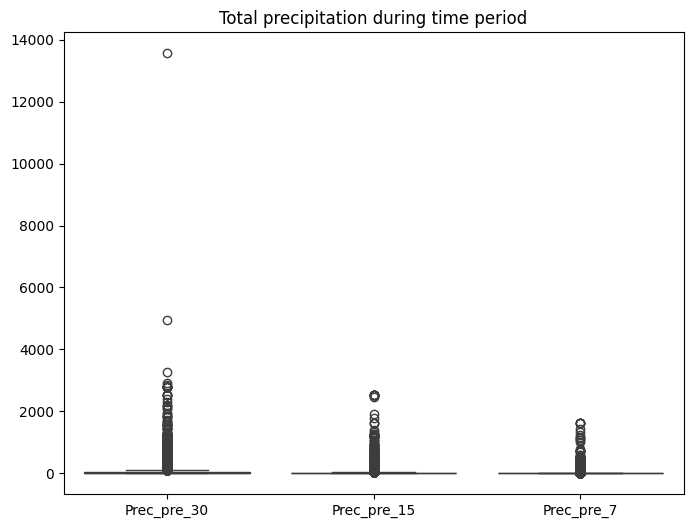

In [ ]:
plt.figure(figsize = (8, 6))
sns.boxplot(data = fires[['Prec_pre_30', 'Prec_pre_15', 'Prec_pre_7']])
plt.title("Total precipitation during time period")
plt.show()

In [ ]:
# Number of records where 30-day precipitation is higher than the highest recorded in the U.S.
(fires['Prec_pre_30'] > 3870).sum()

2

In [ ]:
# Drop the records where 30-day precipitation is impossibly high
fires = fires[fires['Prec_pre_30'] <= 3870]

## **Wildfires per year and per month**

Below, we'll take a look at:
* how the number of fires have changed over the years,
* how the number of fires are distributed across the months of a year,
* the mean fire size across the months of the year, and
* the total area consumed by fires across the months of the year.

We'll see that the number of fires per year seems to have a vaguely positive trend, though with a lot of zig-zagging, and with 2006 having the largest number of fires.

We'll also see that the *number* of fires is largest in the spring months March and April, but the average *size* of fires, as well as the total consumed area, is largest in the summer months of June, July, and August.


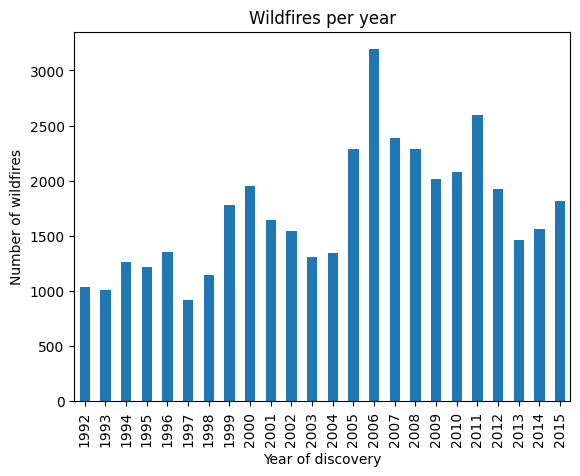

In [ ]:
# Wildfires per year
fires_per_year = fires['discovery_year'].value_counts().sort_index()
ax = fires_per_year.plot(kind = 'bar')
ax.set_title("Wildfires per year")
ax.set_xlabel("Year of discovery")
ax.set_ylabel("Number of wildfires")
plt.show()

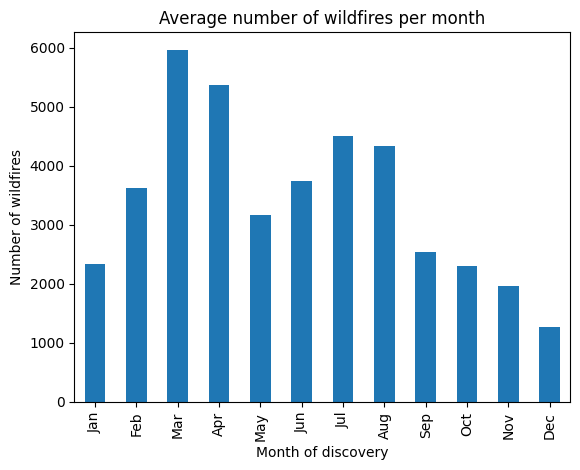

In [ ]:
# Wildfires per month, aggregated for all years
fires_per_month = fires['discovery_month'].value_counts()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', \
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
fires_per_month = fires_per_month.reindex(months)

ax = fires_per_month.plot(kind = 'bar')
ax.set_xlabel("Month of discovery")
ax.set_ylabel("Number of wildfires")
ax.set_title("Average number of wildfires per month")
plt.show()

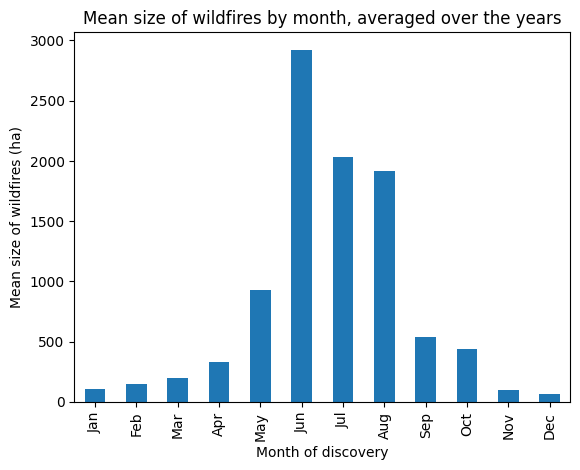

In [ ]:
# Mean fire size by month, aggregated for all years
mean_fire_size_by_month = round(fires.groupby('discovery_month')['fire_size_ha'].mean())
mean_fire_size_by_month = mean_fire_size_by_month.reindex(months)

ax = mean_fire_size_by_month.plot(kind = 'bar')
ax.set_title("Mean size of wildfires by month, averaged over the years")
ax.set_xlabel("Month of discovery")
ax.set_ylabel("Mean size of wildfires (ha)")
plt.show()

Text(0, 0.5, 'Area consumed, average over the years (ha)')

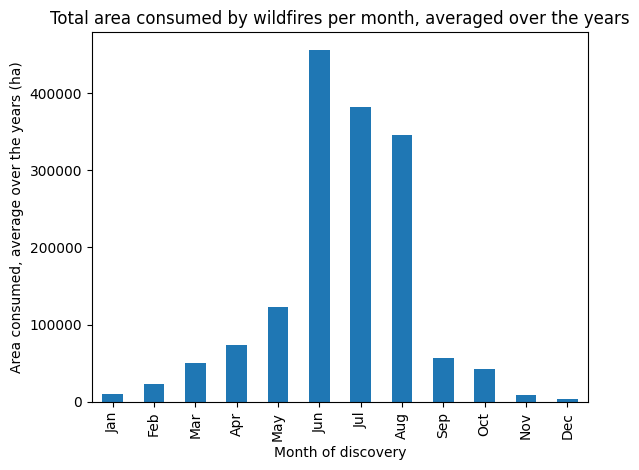

In [ ]:
# Total consumed area per month, average for all years
total_fire_size_by_month = round(fires.groupby('discovery_month')['fire_size_ha'].sum() / 24) # Average for the 24 years in the data
total_fire_size_by_month = total_fire_size_by_month.reindex(months)
ax = total_fire_size_by_month.plot(kind = 'bar')
ax.set_title("Total area consumed by wildfires per month, averaged over the years")
ax.set_xlabel("Month of discovery")
ax.set_ylabel("Area consumed, average over the years (ha)")

## **Skew of the dependent variable**

We'll now take a closer at the dependent variable, **fire_size_ha**, and its log transformation, **ln(fire_size_ha)**.

Applying a log-transform is a way of making skewed data more symmetrical.

The histograms below show us that the log-transformed **ln(fire_size_ha)** is still skewed (and it has a curious bump around 8 for which I don't have any explanation), but it's not as extremely skewed as the **fire_size_ha**, which is in the original scale.

I will use the log-transformed **ln(fire_size_ha)** as the response variable when training the models, since that is likely to generate models with stronger predictive power.

But when reporting metrics such as MAE, RMSE, and MAPE (Mean Absolute Percentage Error), I will calculate them in the original scale; what we care about in the end is how correct the model is in the original scale, not in the log scale.

In [ ]:
# Distribution metrics for fire size in the original and the log-transformed scale
round(fires[['fire_size_ha', 'ln(fire_size_ha)']].describe(), 2)

,fire_size_ha,ln(fire_size_ha)
count,41130.00,41130.00
mean,918.14,1.42
std,6142.55,2.86
min,0.21,-1.58
25%,0.49,-0.72
50%,1.62,0.48
75%,8.09,2.09
max,217740.90,12.29


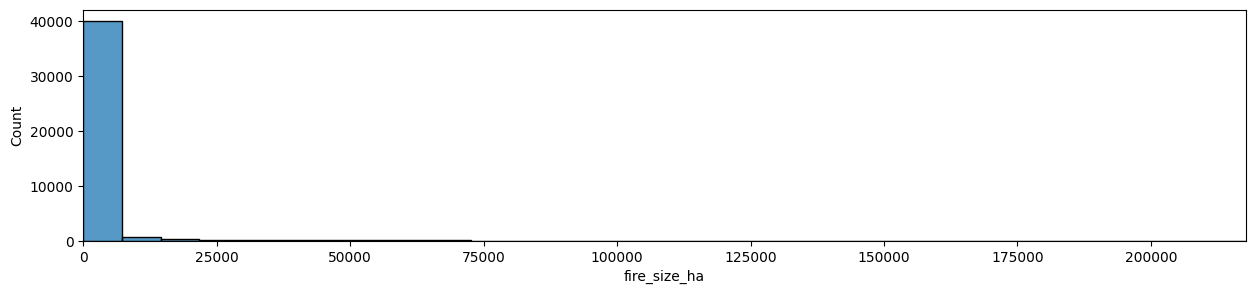

In [ ]:
# Distribution of fire size in the original scale. (Extremely right-skewed.)
plt.figure(figsize=(15, 3))
plt.xlim(0, 217741)
plot = sns.histplot(fires['fire_size_ha'], bins=30)

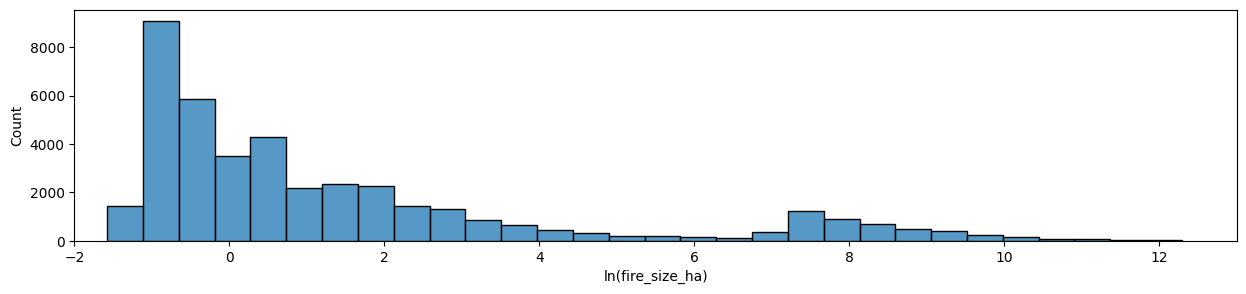

In [ ]:
# Distribution of log-transformed fire size. (Less extremely right-skewed.)
plt.figure(figsize=(15, 3))
plt.xlim(-2, 13)
log_plot = sns.histplot(fires['ln(fire_size_ha)'], bins = 30)

## **Correlation between dependent and independent variables**

To further strengthen the case that we should use the log-transformed fire size, I will look at the correlation between the meteorological predictors and fire size and log-transformed fire size, respectively. (As possible correlations among the predictors is not relevant for this comparison, I truncate the correlation matrix to show only the rows for **fire_size_ha** and **ln(fire_size_ha)**.)

We see that for every predictor, the correlation (positive or negative) with the log-transformed fire size is stronger than the correlation with the fire size in the original scale.

In the second table, we see that the mean absolute correlation between the predictors and the log-transformed fire size is 0.187, while the corresponding number for the the fire size in the original scale is only 0.137.

This indicates that using the log-transformed response variable will likely lead to a model with stronger predictive power.





In [ ]:
# How are the features correlated with the fire size?
corr_cols = ['fire_size_ha', 'ln(fire_size_ha)', 'Temp_pre_30', 'Temp_pre_15', 'Temp_pre_7', \
             'Wind_pre_30', 'Wind_pre_15', 'Wind_pre_7', \
             'Hum_pre_30', 'Hum_pre_15', 'Hum_pre_7', \
             'Prec_pre_30', 'Prec_pre_15', 'Prec_pre_7']

fires[corr_cols].corr(method = 'pearson').iloc[:2, :]

,fire_size_ha,ln(fire_size_ha),Temp_pre_30,Temp_pre_15,Temp_pre_7,Wind_pre_30,Wind_pre_15,Wind_pre_7,Hum_pre_30,Hum_pre_15,Hum_pre_7,Prec_pre_30,Prec_pre_15,Prec_pre_7
fire_size_ha,1.000000,0.437745,0.041654,0.049277,0.055769,-0.004872,-0.001147,-0.001618,-0.093765,-0.077735,-0.075279,-0.037591,-0.027078,-0.020069
ln(fire_size_ha),0.437745,1.000000,0.091489,0.104725,0.114984,0.043487,0.049542,0.040831,-0.219870,-0.183412,-0.174610,-0.068732,-0.049610,-0.036279


In [ ]:
# Mean absolute correlation between the predictors and the fire size, in the original scale and log-transformed
abs(fires[corr_cols].corr(method = 'pearson').iloc[:2, :]).mean(axis = 1)

,0
fire_size_ha,0.137400
ln(fire_size_ha),0.186808


## **Categorical Predictors: Vegetation and discovery_month**



### Vegetation

The Vegetation predictor is categorical. It has 28 levels, numbered from 1 to 28, though only 6 are present in this data set:
4. **Temperate Evergreen Needleleaf Forest**
9. **C3 Grassland/Steppe**
12. **Open Shrubland**
14. **Desert**
15. **Polar Desert/Rock/Ice**
16. **Secondary Tropical Evergreen Broadleaf Forest**


There are 7,190 records with 0 in this column. As mentioned before, I will keep those records, and consider a 0 value to mean that the vegetation type is unknown.

To enable modeling, I will replace the categorical variable with binary dummy variables for the six levels listed above. If all are False, the record belongs to level 0, "unknown".

In [ ]:
# The categorical variable Vegetation
fires['Vegetation'].value_counts()

,count
Vegetation,
12,13061
16,8828
15,8159
0,7190
9,2767
4,636
14,489


In [ ]:
# Replace Vegetion with binary dummy variables
fires_w_dummies = pd.get_dummies(fires, columns = ['Vegetation'], drop_first = True)

### Discovery_month

Though the months of the year form an ordered sequence, they should still be considered a categorical variable. I will replace the 12 levels with `12 - 1 = 11` dummy variables.



In [ ]:
# Create dummy variable for discovery_month,
fires_w_dummies = pd.get_dummies(fires_w_dummies, columns = ['discovery_month'], drop_first = True)

In [ ]:
# Check
fires_w_dummies.columns

Index(['fire_size_ha', 'ln(fire_size_ha)', 'discovery_date', 'discovery_year',
       'Temp_pre_30', 'Temp_pre_15', 'Temp_pre_7', 'Wind_pre_30',
       'Wind_pre_15', 'Wind_pre_7', 'Hum_pre_30', 'Hum_pre_15', 'Hum_pre_7',
       'Prec_pre_30', 'Prec_pre_15', 'Prec_pre_7', 'Vegetation_4',
       'Vegetation_9', 'Vegetation_12', 'Vegetation_14', 'Vegetation_15',
       'Vegetation_16', 'discovery_month_Aug', 'discovery_month_Dec',
       'discovery_month_Feb', 'discovery_month_Jan', 'discovery_month_Jul',
       'discovery_month_Jun', 'discovery_month_Mar', 'discovery_month_May',
       'discovery_month_Nov', 'discovery_month_Oct', 'discovery_month_Sep'],
      dtype='object')

# **Stepwise backward elimination**

I will now use stepwise backward elimination to filter out predictors that are not statistically significant (with a cutoff at p = 0.01).

We'll see that our initial model has a rather low Adjusted R-squared of 0.140, meaning that only 14% of the variation in the target variable (**ln(fire_size_ha)** can be attributed to variations in the predictors. Consequently, the predictive power of the model will probably be rather modest.

We'll also see that eliminating 6 of our initial 29 predictors (including the dummy variables) doesn't lower the Adjusted R-squared; it remains at 0.140, meaning the reduced model has as much predictive power at the full model.

## **Initial set of predictors**


In [ ]:
# Define independent and dependent variables
predictors_before_elimination = ['Temp_pre_30', 'Temp_pre_15', 'Temp_pre_7', \
           'Wind_pre_30', 'Wind_pre_15', 'Wind_pre_7', \
           'Hum_pre_30', 'Hum_pre_15', 'Hum_pre_7', \
           'Prec_pre_30', 'Prec_pre_15', 'Prec_pre_7', \
           'Vegetation_4', 'Vegetation_9', 'Vegetation_12', 'Vegetation_14', 'Vegetation_15', 'Vegetation_16',
           'discovery_month_Jan', 'discovery_month_Feb', 'discovery_month_Mar', \
           'discovery_month_May', 'discovery_month_Jun', 'discovery_month_Jul', 'discovery_month_Aug', \
           'discovery_month_Sep', 'discovery_month_Oct', 'discovery_month_Nov', 'discovery_month_Dec']

print(f"Number of predictors: {len(predictors_before_elimination)}.")

X = fires_w_dummies[predictors_before_elimination].astype(float)

# The log-transformed response variable
y = fires_w_dummies['ln(fire_size_ha)']

Number of predictors: 29.


In [ ]:
# Prepend a column with the constant 1, representing the intercept, as required by the statsmodel library.
X_with_const = sm.add_constant(X)

X_with_const.head()

,const,Temp_pre_30,Temp_pre_15,Temp_pre_7,Wind_pre_30,Wind_pre_15,Wind_pre_7,Hum_pre_30,Hum_pre_15,Hum_pre_7,...,discovery_month_Feb,discovery_month_Mar,discovery_month_May,discovery_month_Jun,discovery_month_Jul,discovery_month_Aug,discovery_month_Sep,discovery_month_Oct,discovery_month_Nov,discovery_month_Dec
8624,1.0,25.867355,24.192917,22.325455,2.939834,3.602101,3.552727,65.873418,58.804255,47.409091,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30793,1.0,11.239130,3.000000,3.000000,2.108824,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20531,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39455,1.0,3.552842,6.801318,4.827586,5.212594,5.361640,5.731440,63.764983,57.175689,66.874227,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39675,1.0,4.417130,8.430556,10.478175,3.952524,4.203519,3.752183,51.199629,48.311111,39.458333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **Linear Regression Model**
We'll use a Linear Regression model for the stepwise backward elimination of predictors.

In [ ]:
def build_model(X, y, remove_var = None):
    """
    Builds and fits an Ordinary Least Squares (OLS) regression model and optionally removes a specified predictor.

    Parameters:
    ----------
    X : pandas.DataFrame
        The input DataFrame containing the predictor variables.
    y : pandas.Series or numpy.ndarray
        The target variable for the regression model.
    remove_var : str, optional (default=None)
        The name of the predictor variable to remove from the input DataFrame `X` before fitting the model.
        If `None`, no predictors are removed.

    Returns:
    -------
    model : statsmodels.regression.linear_model.RegressionResultsWrapper
        The fitted OLS regression model.
    X : pandas.DataFrame
        The modified DataFrame of predictors after removing the specified variable (if any).

    Notes:
    -----
    - The function assumes `X` and `y` are already preprocessed and aligned properly.
    - If `remove_var` is not in `X.columns`, the function will proceed without raising an error or removing any predictors.
    - Prints the model summary to provide information about the model's performance and coefficients.
    """

    if remove_var in X.columns:
        X.drop(columns = remove_var, inplace = True)
    model = sm.OLS(y, X).fit()

    print(model.summary())
    return model, X

In [ ]:
# Full model
model_full, X_full = build_model(X_with_const, y)

                            OLS Regression Results                            
Dep. Variable:       ln(fire_size_ha)   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     231.9
Date:                Fri, 29 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:29:56   Log-Likelihood:                -98523.
No. Observations:               41130   AIC:                         1.971e+05
Df Residuals:                   41100   BIC:                         1.974e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.9762    

In [ ]:
# Reduced model
model_28, X_28 = build_model(X_full, y, remove_var = 'Hum_pre_15')

                            OLS Regression Results                            
Dep. Variable:       ln(fire_size_ha)   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     240.1
Date:                Fri, 29 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:30:22   Log-Likelihood:                -98523.
No. Observations:               41130   AIC:                         1.971e+05
Df Residuals:                   41101   BIC:                         1.974e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.9768    

In [ ]:
# Further reduced model
model_27, X_27 = build_model(X_28, y, remove_var = 'Prec_pre_15')

                            OLS Regression Results                            
Dep. Variable:       ln(fire_size_ha)   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     249.0
Date:                Fri, 29 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:30:25   Log-Likelihood:                -98524.
No. Observations:               41130   AIC:                         1.971e+05
Df Residuals:                   41102   BIC:                         1.973e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.9771    

In [ ]:
# Further reduced model
model_26, X_26 = build_model(X_27, y, remove_var = 'Vegetation_4')

                            OLS Regression Results                            
Dep. Variable:       ln(fire_size_ha)   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     258.5
Date:                Fri, 29 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:30:28   Log-Likelihood:                -98524.
No. Observations:               41130   AIC:                         1.971e+05
Df Residuals:                   41103   BIC:                         1.973e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.9643    

In [ ]:
# Further reduced model
model_25, X_25 = build_model(X_26, y, remove_var = 'Wind_pre_7')

                            OLS Regression Results                            
Dep. Variable:       ln(fire_size_ha)   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     268.8
Date:                Fri, 29 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:30:31   Log-Likelihood:                -98526.
No. Observations:               41130   AIC:                         1.971e+05
Df Residuals:                   41104   BIC:                         1.973e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.9628    

In [ ]:
# Further reduced model
model_24, X_24 = build_model(X_25, y, remove_var = 'Prec_pre_7')

                            OLS Regression Results                            
Dep. Variable:       ln(fire_size_ha)   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     279.9
Date:                Fri, 29 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:30:34   Log-Likelihood:                -98527.
No. Observations:               41130   AIC:                         1.971e+05
Df Residuals:                   41105   BIC:                         1.973e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.9642    

In [ ]:
# Further reduced model
model_23, X_23 = build_model(X_24, y, remove_var = 'Vegetation_14')

                            OLS Regression Results                            
Dep. Variable:       ln(fire_size_ha)   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     291.7
Date:                Fri, 29 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:30:37   Log-Likelihood:                -98530.
No. Observations:               41130   AIC:                         1.971e+05
Df Residuals:                   41106   BIC:                         1.973e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.9446    

# **Final set of predictors**

We now have our final set of predictors.

In [ ]:
reduced_set_of_predictors = X_23.drop(columns = ['const']).columns
print(reduced_set_of_predictors)

Index(['Temp_pre_30', 'Temp_pre_15', 'Temp_pre_7', 'Wind_pre_30',
       'Wind_pre_15', 'Hum_pre_30', 'Hum_pre_7', 'Prec_pre_30', 'Vegetation_9',
       'Vegetation_12', 'Vegetation_15', 'Vegetation_16',
       'discovery_month_Jan', 'discovery_month_Feb', 'discovery_month_Mar',
       'discovery_month_May', 'discovery_month_Jun', 'discovery_month_Jul',
       'discovery_month_Aug', 'discovery_month_Sep', 'discovery_month_Oct',
       'discovery_month_Nov', 'discovery_month_Dec'],
      dtype='object')


# **Split data into training and test sets**

Note that even though I decided above to log-transform the response variable, I here set y to the response variable in the original scale. The reason is that I will calculate performance metrics such as MAE, RMSE, and MAPE error in the original scale. To keep things as straightforward as possible, I will keep y in the original scale and log-transform it on the spot whenever it's used for model training.

In [ ]:
fires_w_dummies.head()

,fire_size_ha,ln(fire_size_ha),discovery_date,discovery_year,Temp_pre_30,Temp_pre_15,Temp_pre_7,Wind_pre_30,Wind_pre_15,Wind_pre_7,...,discovery_month_Dec,discovery_month_Feb,discovery_month_Jan,discovery_month_Jul,discovery_month_Jun,discovery_month_Mar,discovery_month_May,discovery_month_Nov,discovery_month_Oct,discovery_month_Sep
8624,0.404686,-0.904644,1992-10-05,1992,25.867355,24.192917,22.325455,2.939834,3.602101,3.552727,...,False,False,False,False,False,False,False,False,True,False
30793,1.922258,0.653501,1997-03-12,1997,11.239130,3.000000,3.000000,2.108824,0.000000,0.000000,...,False,False,False,False,False,True,False,False,False,False
20531,0.809372,-0.211497,2000-05-19,2000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,False,False,False,False,False,False,True,False,False,False
39455,8.093720,2.091088,2003-04-22,2003,3.552842,6.801318,4.827586,5.212594,5.361640,5.731440,...,False,False,False,False,False,False,False,False,False,False
39675,0.428967,-0.846375,2008-04-21,2008,4.417130,8.430556,10.478175,3.952524,4.203519,3.752183,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# Predictors
X = fires_w_dummies[reduced_set_of_predictors]

# Response variable
y = fires_w_dummies['fire_size_ha']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 456)

In [ ]:
reduced_set_of_predictors

Index(['Temp_pre_30', 'Temp_pre_15', 'Temp_pre_7', 'Wind_pre_30',
       'Wind_pre_15', 'Hum_pre_30', 'Hum_pre_7', 'Prec_pre_30', 'Vegetation_9',
       'Vegetation_12', 'Vegetation_15', 'Vegetation_16',
       'discovery_month_Jan', 'discovery_month_Feb', 'discovery_month_Mar',
       'discovery_month_May', 'discovery_month_Jun', 'discovery_month_Jul',
       'discovery_month_Aug', 'discovery_month_Sep', 'discovery_month_Oct',
       'discovery_month_Nov', 'discovery_month_Dec'],
      dtype='object')

In [ ]:
X_train.head()

,Temp_pre_30,Temp_pre_15,Temp_pre_7,Wind_pre_30,Wind_pre_15,Hum_pre_30,Hum_pre_7,Prec_pre_30,Vegetation_9,Vegetation_12,...,discovery_month_Feb,discovery_month_Mar,discovery_month_May,discovery_month_Jun,discovery_month_Jul,discovery_month_Aug,discovery_month_Sep,discovery_month_Oct,discovery_month_Nov,discovery_month_Dec
49206,19.835842,20.656632,24.706237,2.825071,3.038664,67.945873,66.981132,0.0,False,True,...,False,False,True,False,False,False,False,False,False,False
46031,17.069861,18.379167,15.239881,2.865139,3.088056,64.876900,58.726190,150.0,False,True,...,False,False,True,False,False,False,False,False,False,False
34680,7.223121,8.535156,6.103753,2.594194,2.605763,58.564064,51.978469,21.8,False,True,...,True,False,False,False,False,False,False,False,False,False
26062,12.726257,12.945010,11.933638,4.268563,4.920570,55.641471,74.401408,0.0,False,True,...,False,True,False,False,False,False,False,False,False,False
26048,13.547231,13.715951,14.775824,2.052467,1.480573,72.152760,65.547486,73.3,False,True,...,False,True,False,False,False,False,False,False,False,False


# **Model Wrapper**

To streamline the evaluation of different kinds of models, I'll wrap the model in a custom wrapper class.

The class has a method for running k-fold cross validation, to give us a robust estimate of the model's performance.

It also has method for evaluating the model using a single train/validation split. This method, while giving less robust numbers, is convenient to use during early testing, since it executes approximately k times faster than the k-fold cross-validation. It also provides a sanity check during final testing; the results from the single train/validation split should be reasonably close to those from the cross-validation.

In [ ]:
class ModelWrapper:
    """
    A wrapper class for machine learning models to handle log-transformed targets,
    provide custom scoring metrics, and evaluate models using single validation
    splits or cross-validation.

    Attributes:
    ----------
    model : object
        The machine learning model to be wrapped and trained.
    """

    def __init__(self, model):
        """
        Initializes the ModelWrapper with a given machine learning model.

        Parameters:
        ----------
        model : object
            The machine learning model to be wrapped and trained.
        """

        self.model = model

    # We need custom scorers, so that we can score on values in original scale,
    # even though the models are trained on y-values in log scale.
    def custom_mae(y_true, y_pred):
        """
        Computes Mean Absolute Error (MAE) for log-transformed predictions.

        Parameters:
        ----------
        y_true : array-like
            True target values in the original scale.
        y_pred : array-like
            Predicted target values in the log-transformed scale.

        Returns:
        -------
        float
            The Mean Absolute Error on the original scale.
        """

        return mean_absolute_error(np.exp(y_true), np.exp(y_pred))

    def custom_rmse(y_true, y_pred):
        """
        Computes Root Mean Squared Error (RMSE) for log-transformed predictions.

        Parameters:
        ----------
        y_true : array-like
            True target values in the original scale.
        y_pred : array-like
            Predicted target values in the log-transformed scale.

        Returns:
        -------
        float
            The Root Mean Squared Error on the original scale.
        """

        return root_mean_squared_error(np.exp(y_true), np.exp(y_pred))

    def custom_mape(y_true, y_pred):
        """
        Computes Mean Absolute Percentage Error (MAPE) for log-transformed predictions.

        Parameters:
        ----------
        y_true : array-like
            True target values in the original scale.
        y_pred : array-like
            Predicted target values in the log-transformed scale.

        Returns:
        -------
        float
            The Mean Absolute Percentage Error on the original scale.
        """

        return mean_absolute_percentage_error(np.exp(y_true), np.exp(y_pred))

    # Make the custom scorers
    custom_mae_scorer = make_scorer(custom_mae, greater_is_better=False)
    custom_rmse_scorer = make_scorer(custom_rmse, greater_is_better=False)
    custom_mape_scorer = make_scorer(custom_mape, greater_is_better=False)

    def fit_and_evaluate_model_with_single_validation_split(self, X, y): # y is in original scale
        """
        Trains and evaluates the model using a single train-test split.

        Parameters:
        ----------
        X : pandas.DataFrame or numpy.ndarray
            Predictor variables.
        y : pandas.Series or numpy.ndarray
            Target variable in the original scale.

        Returns:
        -------
        tuple of floats
            The Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and
            Mean Absolute Percentage Error (MAPE) on the test set.
        """

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

        # Fit the model to the training data
        self.model.fit(X_train, np.log(y_train)) # Train the model using the log-transform of y

        # Make predictions on the test set
        y_pred = self.model.predict(X_test) # y_pred will be in log scale, since the model was trained on log-scaled y:s

        mae = mean_absolute_error(y_test, np.exp(y_pred)) # Convert y_pred to original scale for the metrics calculations
        rmse = root_mean_squared_error(y_test, np.exp(y_pred))
        mape = mean_absolute_percentage_error(y_test, np.exp(y_pred))

        return mae, rmse, mape

    def fit_and_evaluate_model_using_cross_validation(self, X, y, cv = 5):
        """
        Trains and evaluates the model using cross-validation with custom metrics.

        Parameters:
        ----------
        X : pandas.DataFrame or numpy.ndarray
            Predictor variables.
        y : pandas.Series or numpy.ndarray
            Target variable in the original scale.
        cv : int, optional (default=5)
            Number of cross-validation folds.

        Returns:
        -------
        dict
            A dictionary containing the mean and standard deviation of custom metrics
            across the folds, as well as predictions on the original scale.
        """

        # Cross-validation for scoring metrics (log-transformed y)
        mae_scores = cross_val_score(self.model, X, np.log(y), cv=cv, scoring=self.custom_mae_scorer)
        rmse_scores = cross_val_score(self.model, X, np.log(y), cv=cv, scoring=self.custom_rmse_scorer)
        mape_scores = cross_val_score(self.model, X, np.log(y), cv=cv, scoring=self.custom_mape_scorer)

        # Get the metrics
        mae_mean = -mae_scores.mean()
        mae_std = mae_scores.std()
        rmse_mean = -rmse_scores.mean()
        rmse_std = rmse_scores.std()
        mape_mean = -mape_scores.mean()
        mape_std = mape_scores.std()

        # Generate predictions for all folds
        y_preds_log = cross_val_predict(self.model, X, np.log(y), cv = cv) # Preds are in log scale
        y_preds_orig_scale = np.exp(y_preds_log)  # Convert preds to original scale

        results = {
            'mae_mean': mae_mean,
            'mae_std': mae_std,
            'rmse_mean': rmse_mean,
            'rmse_std': rmse_std,
            'mape_mean': mape_mean,
            'mape_std': mape_std,
            'y_preds_orig_scale': y_preds_orig_scale
        }

        return results

    def add_results_to_df(self, results_df, results, row_name):
        """
        Appends evaluation results to a DataFrame.

        Parameters:
        ----------
        results_df : pandas.DataFrame
            DataFrame containing previous evaluation results.
        results : dict
            Dictionary of evaluation results to append.
        row_name : str
            Name of the row to append.

        Returns:
        -------
        pandas.DataFrame
            Updated DataFrame with appended results.
        """

        # Add the results to our table
        new_row = pd.DataFrame([{
            'Model': row_name,
            'MAE': f"{results['mae_mean']:.2f} ± {results['mae_std']:.2f}",
            'RMSE': f"{results['rmse_mean']:.2f}± {results['rmse_std']:.2f}",
            'MAPE': f"{results['mape_mean']:.2f} ± {results['mape_std']:.2f}"
        }])

        results_df = pd.concat([results_df, new_row], ignore_index = True)

        return results_df

    def fit_model_on_entire_training_set(self, X_train, y_train):
        """
        Fits the model to the entire training set using log-transformed targets.

        Parameters:
        ----------
        X_train : pandas.DataFrame or numpy.ndarray
            Predictor variables for training.
        y_train : pandas.Series or numpy.ndarray
            Target variable in the original scale.
        """

        self.model.fit(X_train, np.log(y_train))

        return None

    def evaluate_model_on_test_set(self, X_test, y_test, orig_scale = True):
        """
        Evaluates the model on the test set and calculates metrics.

        Parameters:
        ----------
        X_test : pandas.DataFrame or numpy.ndarray
            Predictor variables for testing.
        y_test : pandas.Series or numpy.ndarray
            True target values in the original scale.
        orig_scale : bool, optional (default=True)
            Whether to convert predictions back to the original scale.

        Returns:
        -------
        tuple of floats
            The Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and
            Mean Absolute Percentage Error (MAPE) on the test set.
        """

        # Make predictions (log scale)
        y_pred = self.model.predict(X_test)

        if orig_scale:
            # Convert predictions to original scale
            y_pred = np.exp(y_pred)

        # Calculate metrics in original scale
        mae = mean_absolute_error(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)

        # Mean Abslute Error, Root Mean Squared Error, Mean Absolute Percentage Error
        return mae, rmse, mape

# **Naive and Naive-by-Month Benchmarks**

I will evaluate the models on Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE).

To generate naive benchmarks for these metrics, I will take the unusual step of making not just one, but four naive predictions for each fire size:
* **Naive prediction 1**. Mean of all fire sizes.
* **Naive prediction 2**. Median of all fire sizes.
* **Naive-by-month prediction 1**. Mean of all fire sizes from the same month as the fire whose size we are trying to predict.
* **Naive-by-month prediction 2**. Median of all fire sizes from the same month as the fire whose size we are trying to predict.

So why use four naive predictions for each fire, leading to four separate sets of naive benchmarks?

My thinking is that you should use whichever easy-to-compute benchmark is hardest to beat. If a model can beat a benchmark based on the mean of all fires, but it's performing worse than a benchmark based on the median, then it's still not a useful model.

We saw above the the mean size of fires varied across the year, and even if we don't have access to any meteorological information, we always know which month it is, so if you get a better (and thus harder-to-beat) benchmark by predicting the size of the fire to be the mean or median size for that month of the year, then that's the benchmark you should use.

To find which set of benchmark performs the best, I will calculate them all.




In [ ]:
# Add naive predictions to each row. (The same for all fires.)
fires['mean'] = fires['fire_size_ha'].mean()     # Naive prediction 1: mean of all fire sizes
fires['median'] = fires['fire_size_ha'].median() # Naive prediction 2: median of all fire sizes

# Add naive-by-month predictions to each row. (The same for all fires within the same month.)
mean_fire_size_by_month = fires.groupby('discovery_month')['fire_size_ha'].mean()
fires['mean_by_month'] = fires['discovery_month'].map(mean_fire_size_by_month)     # Naive-by-month prediction 1: mean of fire sizes for that month

median_fire_size_by_month = fires.groupby('discovery_month')['fire_size_ha'].median()
fires['median_by_month'] = fires['discovery_month'].map(median_fire_size_by_month) # Naive-by-month prediction 1: median of fire sizes for that month

# Naive benchmarks 1: based on the mean
mae_naive_mean  = mean_absolute_error(fires['fire_size_ha'], fires['mean'])
rmse_naive_mean = root_mean_squared_error(fires['fire_size_ha'], fires['mean'])
mape_naive_mean = mean_absolute_percentage_error(fires['fire_size_ha'], fires['mean'])

# Naive benchmarks 2: based on the median
mae_naive_median  = mean_absolute_error(fires['fire_size_ha'], fires['median'])
rmse_naive_median = root_mean_squared_error(fires['fire_size_ha'], fires['median'])
mape_naive_median = mean_absolute_percentage_error(fires['fire_size_ha'], fires['median'])

# Naive-by-month benchmarks 1: based on mean
mea_naive_by_month_mean  = mean_absolute_error(fires['fire_size_ha'], fires['mean_by_month'])
rmse_naive_by_month_mean = root_mean_squared_error(fires['fire_size_ha'], fires['mean_by_month'])
mape_naive_by_month_mean = mean_absolute_percentage_error(fires['fire_size_ha'], fires['mean_by_month'])

# Naive-by-month benchmarks 2: based on median
mea_naive_by_month_median  = mean_absolute_error(fires['fire_size_ha'], fires['median_by_month'])
rmse_naive_by_month_median = root_mean_squared_error(fires['fire_size_ha'], fires['median_by_month'])
mape_naive_by_month_median = mean_absolute_percentage_error(fires['fire_size_ha'], fires['median_by_month'])

In [ ]:
# Put the naive benchmarks in a df
benchmark_df = pd.DataFrame([{
    'Model': 'Naive benchmark (mean-based)',
    'MAE': f"{mae_naive_mean:.2f}",
    'RMSE': f"{rmse_naive_mean:.2f}",
    'MAPE': f"{mape_naive_mean:.2f}"
}, {
    'Model': 'Naive-by-month benchmark (mean-based)',
    'MAE': f"{mea_naive_by_month_mean:.2f}",
    'RMSE': f"{rmse_naive_by_month_mean:.2f}",
    'MAPE': f"{mape_naive_by_month_mean:.2f}"
}, {
    'Model': 'Naive benchmark (median-based)',
    'MAE': f"{mae_naive_median:.2f}",
    'RMSE': f"{rmse_naive_median:.2f}",
    'MAPE': f"{mape_naive_median:.2f}"
}, {
    'Model': 'Naive-by-month benchmark (median-based)',
    'MAE': f"{mea_naive_by_month_median:.2f}",
    'RMSE': f"{rmse_naive_by_month_median:.2f}",
    'MAPE': f"{mape_naive_by_month_median:.2f}"
}])

results_df = benchmark_df.copy()

results_df

,Model,MAE,RMSE,MAPE
0,Naive benchmark (mean-based),1610.60,6142.47,956.55
1,Naive-by-month benchmark (mean-based),1465.86,6069.49,873.56
2,Naive benchmark (median-based),917.48,6210.47,1.38
3,Naive-by-month benchmark (median-based),917.45,6210.39,1.41


# **Models to evaluate**

## **Linear Regression**

We already trained Linear Regresssion models above, when performing the paramater elimination – but those models were trained on all observations in the dataset, i.e. before splitting of a test set. We must now train a new Linear Regression model, using only the training set.

Also, when doing the parameter elimation, we used Statsmodel to build our model, since it provides a nice model summary with p-numbers. Now that we no longer need such a summary, we'll use scikit-learn's LinearRegression function.

In [ ]:
# Instantiate a ModelWrapper object
lr_wrapper = ModelWrapper(LinearRegression())

# Evaluate the model using a single training/validation split
mae, rmse, mape = lr_wrapper.fit_and_evaluate_model_with_single_validation_split(X_train, y_train)

# Output performance metrics based on single training/validation split
print(f"MAE in original scale: {mae:.2f}")
print(f"RMSE in original scale: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")

# Evaluate the model using cross-validation
lr_results = lr_wrapper.fit_and_evaluate_model_using_cross_validation(X_train, y_train)

# Add the results to the results table
results_df = lr_wrapper.add_results_to_df(results_df, lr_results, 'LinearRegression')

results_df

MAE in original scale: 941.12
RMSE in original scale: 6360.78
MAPE: 5.85


,Model,MAE,RMSE,MAPE
0,Naive benchmark (mean-based),1610.60,6142.47,956.55
1,Naive-by-month benchmark (mean-based),1465.86,6069.49,873.56
2,Naive benchmark (median-based),917.48,6210.47,1.38
3,Naive-by-month benchmark (median-based),917.45,6210.39,1.41
4,LinearRegression,924.59 ± 44.22,6294.76± 558.89,6.28 ± 0.28


## **Support Vector Regression (SVR)**

As the name implies, SVR uses Support Vector Machines (SVMs) for regression.


### Standardize the predictors
Before training the model, we'll standardize all continuous variables, i.e. center them on 0, with a standard deviation of 1. The binary dummy variables (for Vegetation and Month) need no standardization.

In [ ]:
# Initialize the scaler
scaler = StandardScaler()

# Columns with continuous variables
columns_continuous = ['Temp_pre_7', 'Temp_pre_15', 'Temp_pre_30', 'Wind_pre_15', 'Wind_pre_30', \
                      'Hum_pre_7', 'Hum_pre_30', 'Prec_pre_30']

# Make copies to hold our scaled predictors
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Fit the scaler on the data and transform it
X_train_scaled[columns_continuous] = scaler.fit_transform(X_train[columns_continuous])
X_test_scaled[columns_continuous] = scaler.transform(X_test[columns_continuous])

# Check that the continous variables look standardized, and that the binary dummy variables remain True and False
X_train_scaled.head()

,Temp_pre_30,Temp_pre_15,Temp_pre_7,Wind_pre_30,Wind_pre_15,Hum_pre_30,Hum_pre_7,Prec_pre_30,Vegetation_9,Vegetation_12,...,discovery_month_Feb,discovery_month_Mar,discovery_month_May,discovery_month_Jun,discovery_month_Jul,discovery_month_Aug,discovery_month_Sep,discovery_month_Oct,discovery_month_Nov,discovery_month_Dec
49206,0.555222,0.616186,1.011571,-0.077330,0.145930,0.575847,0.684606,-0.325083,False,True,...,False,False,True,False,False,False,False,False,False,False
46031,0.253586,0.372806,0.021742,-0.048633,0.178798,0.437168,0.350017,1.057816,False,True,...,False,False,True,False,False,False,False,False,False,False
34680,-0.820219,-0.679171,-0.933557,-0.242682,-0.142149,0.151906,0.076518,-0.124101,False,True,...,True,False,False,False,False,False,False,False,False,False
26062,-0.220092,-0.207913,-0.323968,0.956489,1.398268,0.019841,0.985365,-0.325083,False,True,...,False,True,False,False,False,False,False,False,False,False
26048,-0.130563,-0.125527,-0.026781,-0.630663,-0.890921,0.765946,0.626498,0.350694,False,True,...,False,True,False,False,False,False,False,False,False,False


### Train and evaluate the SVR model

In [ ]:
%%time
# Initialize the SVR model
svr_wrapper = ModelWrapper(SVR(kernel='rbf'))  # Try 'rbf', 'linear', 'poly'

# Evaluate the model using a single train/validation set split
mae, rmse, mape = svr_wrapper.fit_and_evaluate_model_with_single_validation_split(X_train_scaled, y_train)

# Output performance metrics based on single training/validation split
print(f"MAE in original scale: {mae:.2f}")
print(f"RMSE in original scale: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")

# Evaluate the model using cross-validation
svr_results = svr_wrapper.fit_and_evaluate_model_using_cross_validation(X_train_scaled, y_train)

# Add the results to the results table
results_df = svr_wrapper.add_results_to_df(results_df, svr_results, 'SVR')

results_df

MAE in original scale: 928.89
RMSE in original scale: 6327.55
MAPE: 8.35
CPU times: user 15min 23s, sys: 2.73 s, total: 15min 26s
Wall time: 15min 22s


,Model,MAE,RMSE,MAPE
0,Naive benchmark (mean-based),1610.60,6142.47,956.55
1,Naive-by-month benchmark (mean-based),1465.86,6069.49,873.56
2,Naive benchmark (median-based),917.48,6210.47,1.38
3,Naive-by-month benchmark (median-based),917.45,6210.39,1.41
4,LinearRegression,924.59 ± 44.22,6294.76± 558.89,6.28 ± 0.28
5,SVR,912.30 ± 43.62,6257.33± 564.94,10.01 ± 1.68


## **Random Forest**



### Hyper-parameter grid search

To get a good Random Forest model, we need to tune the hyper-parameters. The hyper-parameter grid below has $4 \times 5 \times 3 \times 3 \times 3 = 540$ combinations. To keep the computation time reasonable, I'll explore a random selection of 50 of these combination and use cross-validation with just 3 folds, instead of the more commonly used 5 folds.

In [ ]:
%%time
def rf_parameter_search(X_train, y_train):
    """
    Performs hyperparameter tuning for a Random Forest Regressor using RandomizedSearchCV.

    Parameters:
    ----------
    X_train : pandas.DataFrame or numpy.ndarray
        The training data containing the predictor variables.
    y_train : pandas.Series or numpy.ndarray
        The target variable corresponding to the training data.

    Returns:
    -------
    RandomizedSearchCV object
        The result of the randomized search, containing the best parameters and scores.

    Notes:
    -----
    - The function defines a parameter grid for the Random Forest Regressor, including:
        - 'n_estimators': Number of trees in the forest.
        - 'max_depth': Maximum depth of the trees.
        - 'min_samples_split': Minimum number of samples required to split an internal node.
        - 'min_samples_leaf': Minimum number of samples required to be at a leaf node.
        - 'max_features': Number of features to consider when looking for the best split.
    - The search is performed using RandomizedSearchCV with 50 iterations and 3-fold cross-validation.
    - The scoring metric used is negative root mean squared error ('neg_root_mean_squared_error').
    """

    # Define the parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 10, 20, 30, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [None, 'sqrt', 'log2']
    }

    # Initialize the model
    rf = RandomForestRegressor(random_state=42)

    # Set up Randomized Search
    random_search = RandomizedSearchCV(
        estimator = rf,
        param_distributions=param_grid,
        n_iter = 50,  # Number of parameter settings sampled. For final run: 50
        cv = 3, # Number of folds for cross-validation
        scoring='neg_root_mean_squared_error',
        n_jobs= - 1,
        random_state = 42,
        verbose = 2
    )

    # Fit the random search
    random_search_result = random_search.fit(X, y)

    return random_search_result

# Load saved hyper-parameters, if there are any
try:
    with open(os.path.join(GENERATED_FILES_DIR, 'rf_best_score.json'), 'r') as f:
        rf_best_score = json.load(f)
    with open(os.path.join(GENERATED_FILES_DIR, 'rf_best_params.json'), 'r') as f:
        rf_best_params = json.load(f)
except:
    # There are no saved hyper-parameter, so execute the grid-search
    random_search_result = rf_parameter_search(X, y)

    # Extract the best score and best hyper-parameters
    rf_best_score = random_search_result.best_score_
    rf_best_params = random_search_result.best_params_

    # Save the best score and hyper-parameters
    with open(os.path.join(GENERATED_FILES_DIR, 'rf_best_score.json'), 'w') as f:
        json.dump(rf_best_score, f)
    with open(os.path.join(GENERATED_FILES_DIR, 'rf_best_params.json'), 'w') as f:
        json.dump(rf_best_params, f)

# Print best score and hyper-parameters
print("Best RMSE:", np.exp(-rf_best_score))
print("Best Parameters:", rf_best_params)

Best RMSE: inf
Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
CPU times: user 5.88 ms, sys: 2 µs, total: 5.88 ms
Wall time: 938 ms


<timed exec>:52: RuntimeWarning: overflow encountered in exp


### Train and evaluate the Random Forest model

We train a Random Forest model using the best combination of hyper-parameters found above.

In [ ]:
%%time
# Initialize the Random Forest model with the best combination of parameters
rf_best_model = RandomForestRegressor(n_estimators = rf_best_params['n_estimators'],
                                 min_samples_split = rf_best_params['min_samples_split'],
                                 min_samples_leaf = rf_best_params['min_samples_leaf'],
                                 max_features = rf_best_params['max_features'],
                                 max_depth = rf_best_params['max_depth'],
                                 random_state = 42)

rf_wrapper = ModelWrapper(rf_best_model)

# Evaluate the model using a single train/validation set split
mae, rmse, mape = rf_wrapper.fit_and_evaluate_model_with_single_validation_split(X_train, y_train)

# Output Mean Absolute Deviation and Root Mean Squared Error
print(f"MAE in original scale: {mae:.2f}")
print(f"RMSE in original scale: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")

# Evaluate the model using cross-validation
rf_results = rf_wrapper.fit_and_evaluate_model_using_cross_validation(X_train, y_train)

# Add the results to our table
results_df = rf_wrapper.add_results_to_df(results_df, rf_results, 'RandomForest')

results_df

MAE in original scale: 912.77
RMSE in original scale: 6265.99
MAPE: 10.54
CPU times: user 7min 3s, sys: 2.43 s, total: 7min 5s
Wall time: 7min 4s


,Model,MAE,RMSE,MAPE
0,Naive benchmark (mean-based),1610.60,6142.47,956.55
1,Naive-by-month benchmark (mean-based),1465.86,6069.49,873.56
2,Naive benchmark (median-based),917.48,6210.47,1.38
3,Naive-by-month benchmark (median-based),917.45,6210.39,1.41
4,LinearRegression,924.59 ± 44.22,6294.76± 558.89,6.28 ± 0.28
5,SVR,912.30 ± 43.62,6257.33± 564.94,10.01 ± 1.68
6,RandomForest,894.40 ± 41.11,6153.84± 548.55,10.70 ± 1.89


## **Neural Network**

We'll explore a simple Feed-Forward Neural Network.

### Hyper-parameter grid search

As with the Random Forest, we need to tune the hyper-parameters for the Neural Network. To facilitate the tuning, I'll wrap the model in a custom class. The hyper-parameter grid has $3 \times 2 \times 2 \times 3 \times 3 = 108$ combinations. I'll explore a random selection of 30 of these, using 3-fold cross validition.


In [ ]:
# Define a custom wrapper class for the Keras model
class KerasModelWrapper(BaseEstimator, RegressorMixin):
    """
    A custom scikit-learn wrapper for Keras models, allowing for hyperparameter tuning
    and seamless integration with scikit-learn tools like cross-validation.

    Attributes:
    ----------
    optimizer : str
        The optimizer to use for training the model ('adam' or 'sgd').
    init : str
        The initializer for the kernel weights of the layers (e.g., 'he_normal').
    batch_size : int
        The number of samples per batch during training.
    epochs : int
        The maximum number of training epochs.
    patience : int
        The number of epochs with no improvement on validation loss before early stopping.
    learning_rate : float
        The learning rate for the optimizer.
    dropout_rate : float
        The dropout rate for regularization in the hidden layers.

    Methods:
    -------
    build_model():
        Builds the Keras model with the specified architecture and hyperparameters.

    fit(X, y):
        Trains the Keras model using the training data.

    predict(X):
        Generates predictions using the trained Keras model.
    """

    def __init__(self, optimizer = 'adam',
                 init = 'he_normal',
                 batch_size = 10,
                 epochs = 100,
                 patience = 5,
                 learning_rate = 0.001,
                 dropout_rate = 0.5):
        """
        Initializes the KerasModelWrapper with the specified hyperparameters.

        Parameters:
        ----------
        optimizer : str, optional (default='adam')
            The optimizer to use for training ('adam' or 'sgd').
        init : str, optional (default='he_normal')
            The kernel initializer for the layers.
        batch_size : int, optional (default=10)
            The batch size for training.
        epochs : int, optional (default=100)
            The maximum number of training epochs.
        patience : int, optional (default=5)
            The number of epochs with no validation loss improvement before stopping.
        learning_rate : float, optional (default=0.001)
            The learning rate for the optimizer.
        dropout_rate : float, optional (default=0.5)
            The dropout rate for regularization in the dense layers.
        """

        self.optimizer = optimizer
        self.init = init
        self.batch_size = batch_size
        self.epochs = epochs
        self.patience = patience  # Add patience attribute
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate

    def build_model(self):
        """
        Constructs the Keras model with a specified architecture and hyperparameters.

        Returns:
        -------
        model : keras.Sequential
            The compiled Keras model.
        """

        model = Sequential()
        Input(shape=(X_train.shape[1],)),  # Define the input layer explicitly
        model.add(Dense(64, kernel_initializer=self.init, activation='relu'))
        model.add(Dropout(self.dropout_rate))
        model.add(Dense(32, kernel_initializer=self.init, activation='relu'))
        model.add(Dropout(self.dropout_rate))
        model.add(Dense(1, kernel_initializer=self.init))

        # Set optimizer with the specified learning rate
        if self.optimizer == 'adam':
            optimizer = Adam(learning_rate=self.learning_rate)
        elif self.optimizer == 'sgd':
            optimizer = SGD(learning_rate=self.learning_rate)

        model.compile(loss='mse', optimizer = optimizer)
        return model

    def fit(self, X, y):
        """
        Trains the Keras model using the provided training data.

        Parameters:
        ----------
        X : numpy.ndarray or pandas.DataFrame
            Training features.
        y : numpy.ndarray or pandas.Series
            Training target variable.

        Returns:
        -------
        self : KerasModelWrapper
            The fitted model instance.
        """

        self.model = self.build_model()
        early_stopping = EarlyStopping(monitor='val_loss',
                                       patience=self.patience,
                                       restore_best_weights=True)
        self.model.fit(
            X, y,
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=0,
            validation_split=0.1,  # Use 10% of training data for validation
            callbacks=[early_stopping]
        )
        return self

    def predict(self, X):
        """
        Generates predictions using the trained Keras model.

        Parameters:
        ----------
        X : numpy.ndarray or pandas.DataFrame
            Test features.

        Returns:
        -------
        numpy.ndarray
            Predicted values as a 1D array.
        """

        return self.model.predict(X).flatten()

In [ ]:
%%time
def nn_parameter_search(param_grid, X_train_scaled, y_train):
    """
    Performs hyperparameter tuning for a neural network model wrapped with KerasModelWrapper
    using RandomizedSearchCV.

    Parameters:
    ----------
    param_grid : dict
        A dictionary containing the hyperparameter distributions to sample from. The keys
        represent the hyperparameters, and the values are the possible values or distributions
        for sampling.
    X_train_scaled : numpy.ndarray or pandas.DataFrame
        The scaled training data for the predictor variables.
    y_train : numpy.ndarray or pandas.Series
        The target variable corresponding to the training data.

    Returns:
    -------
    RandomizedSearchCV object
        The result of the randomized search, containing the best parameters and scores.

    Notes:
    -----
    - RandomizedSearchCV is used for sampling hyperparameter combinations from the specified
      grid, with k-fold cross-validation.
    - The search leverages the KerasModelWrapper, enabling integration with scikit-learn.
    - The search is parallelized using `n_jobs=-1`.
    """

    # Create the RandomizedSearchCV object with the custom wrapper
    random_search = RandomizedSearchCV(estimator = KerasModelWrapper(),
                                    param_distributions = param_grid,
                                    n_iter = 30, # Number of parameter settings sampled. For final run: 30
                                    n_jobs = -1,
                                    cv = 3,  # Number of folds for cross-validation
                                    random_state = 42)

    random_search_result = random_search.fit(X_train_scaled, y_train)

    return random_search_result

# Define the grid search parameters
nn_param_grid = {
    'batch_size': [10, 20, 50],
    'optimizer': ['adam', 'sgd'],
    'init': ['he_normal', 'glorot_uniform'],
    'learning_rate': [0.1, 0.01, 0.001],
    'dropout_rate': [0.0, 0.2, 0.5]
}

# Load saved hyper-parameter, if there are any
try:
    with open(os.path.join(GENERATED_FILES_DIR, 'nn_best_score.json'), 'r') as f:
        nn_best_score = json.load(f)
    with open(os.path.join(GENERATED_FILES_DIR, 'nn_best_params.json'), 'r') as f:
        nn_best_params = json.load(f)
except:
    # There are no saved hyper-parameter, so execute the grid-search
    random_search_result = nn_parameter_search(nn_param_grid, X_train_scaled, y_train)

    # Extract the best score and best hyper-parameters
    nn_best_score = random_search_result.best_score_
    nn_best_params = random_search_result.best_params_

    # Save the best score and hyper-parameters
    with open(os.path.join(GENERATED_FILES_DIR, 'nn_best_score.json'), 'w') as f:
        json.dump(nn_best_score, f)
    with open(os.path.join(GENERATED_FILES_DIR, 'nn_best_params.json'), 'w') as f:
        json.dump(nn_best_params, f)

# Display the best parameters
print("Best score:", nn_best_score)
print("Best Parameters:", nn_best_params)

Best score: 0.2607938339142037
Best Parameters: {'optimizer': 'adam', 'learning_rate': 0.01, 'init': 'he_normal', 'dropout_rate': 0.5, 'batch_size': 20}
CPU times: user 2.74 ms, sys: 3 ms, total: 5.73 ms
Wall time: 776 ms


### Train and evaluate the Neural Network
We train a Neural Network using the best combination of hyper-parameters found above.

The Neural Network takes the same standardized data that we used for SVR.

In [ ]:
# Define the best model with optimal parameters from the grid search
nn_best_model = KerasModelWrapper(
    optimizer = nn_best_params['optimizer'],
    init = nn_best_params['init'],
    batch_size = nn_best_params['batch_size'],
    learning_rate = nn_best_params['learning_rate'],
    dropout_rate = nn_best_params['dropout_rate']
)

In [ ]:
%%time
# Create a model with the best combination of hyper-parameters
nn_wrapper = ModelWrapper(nn_best_model)

# Evaluate the model using a single train/validation set split
mae, rmse, mape = nn_wrapper.fit_and_evaluate_model_with_single_validation_split(X_train_scaled, y_train)

# Output Mean Absolute Deviation and Root Mean Squared Error
print(f"MAE in original scale: {mae:.2f}")
print(f"RMSE in original scale: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")

# Evaluate the model using cross-validation
nn_results = nn_wrapper.fit_and_evaluate_model_using_cross_validation(X_train_scaled, y_train)

# Add the results to our table
results_df = nn_wrapper.add_results_to_df(results_df, nn_results, 'Feed-Forward NN')

206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MAE in original scale: 937.28
RMSE in original scale: 6351.03
MAPE: 4.63
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
CPU times: user 9min 26s, sys: 52 s, total: 10min 18s
Wall time: 7

# **Evaluating the cross-validation results**

## **Comparing models on the cross-validation metrics**

No model is the best one on all cross-validation metrics. The Random Forest has the best MAE and RMSE, while Linear Regression has the best MAPE. But, on the latter metric, the median-based benchmarks far outperform any of the models.

(Note that the numbers for MAPE aren't actually percentages, but portions; the 1.38 for the Naive benchmark (median-based) means that that benchmark is, on average, off by a factor of 1.38, i.e. 138%.)


In [ ]:
results_df

,Model,MAE,RMSE,MAPE
0,Naive benchmark (mean-based),1610.60,6142.47,956.55
1,Naive-by-month benchmark (mean-based),1465.86,6069.49,873.56
2,Naive benchmark (median-based),917.48,6210.47,1.38
3,Naive-by-month benchmark (median-based),917.45,6210.39,1.41
4,LinearRegression,924.59 ± 44.22,6294.76± 558.89,6.28 ± 0.28
5,SVR,912.30 ± 43.62,6257.33± 564.94,10.01 ± 1.68
6,RandomForest,894.40 ± 41.11,6153.84± 548.55,10.70 ± 1.89
7,Feed-Forward NN,920.93 ± 42.82,6402.16± 661.77,8.25 ± 1.40


## **REC Curve**

For visualizing the performance of classification models, we often plot the [Receiver Operating Characteristic (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve.

For regression tasks, there is a lesser-known analog, called the **Receiver Error Characteristic (REC)**, which was presented by Jinbo Bi and Kristin P. Bennett in their 2003 paper [Regression Error Characteristic Curves](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://cdn.aaai.org/ICML/2003/ICML03-009.pdf).

The REC plots the tolerance, i.e. the largest absolute error we are willing to accept, on the x-axis, and the portion of all precitions that have a smaller absolute error than the tolerance on the y-axis.

The predictions used for the REC curves below come from the cross-validation.

### Generate the REC Curve

In [ ]:
# Naive benchmark, mean-based
y_mean = fires['mean']

# Naive benchmark, median-based
y_median = fires['median']

# Naive-by-month benchmark: mean-based
y_mean_by_month = fires['mean_by_month']

# Naive-by-month benchmark: median-based
y_median_by_month = fires['median_by_month']

# Linear Regressions
y_preds_lr = lr_results['y_preds_orig_scale']

# SVR predictions
y_preds_svr = svr_results['y_preds_orig_scale']

# RandomForest predictions
y_preds_rf = rf_results['y_preds_orig_scale']

# Feed-Forward Neural Network predictions
y_pred_nn = nn_results['y_preds_orig_scale']

In [ ]:
def plot_rec_curve(models, y_true, y_preds, max_error=None):
    """
    Plots the Receiver Error Characteristic (REC) curve for one or more models
    using absolute errors. The REC curve visualizes the cumulative distribution
    of prediction errors, providing insights into model performance.

    Parameters:
    ----------
    models : list of str
        A list of model names corresponding to the predictions provided in `y_preds`.
    y_true : numpy.ndarray or pandas.Series
        The true target values.
    y_preds : list of numpy.ndarray or pandas.Series
        A list of predicted values, where each element corresponds to predictions
        made by one of the models in `models`.
    max_error : float, optional (default=None)
        The maximum error to display on the x-axis. If `None`, the x-axis will scale
        automatically to the range of the errors.

    Returns:
    -------
    None
        Displays the REC curve plot. Does not return any object.

    Notes:
    -----
    - The REC curve plots the absolute prediction errors against the cumulative
      proportion of predictions, providing an aggregated measure of error distribution.
    - The Area Under the REC Curve (AUC-REC) is calculated using the trapezoidal rule
      and displayed in the legend for each model..
    """

    plt.figure(figsize=(8, 6))

    for model, y_pred in zip(models, y_preds):
        abs_errors = np.abs(y_true - y_pred)
        sorted_errors = np.sort(abs_errors)

        # Calculate cumulative proportions
        cumulative_proportion = np.linspace(0, 1, len(sorted_errors))

        # Calculate AUC-REC using the trapezoidal rule
        auc_rec = np.trapz(cumulative_proportion, x=sorted_errors)

        # Plot the REC curve
        plt.plot(sorted_errors, cumulative_proportion, label=f"{model}. AUC: {auc_rec.astype(int)}")


    plt.xlabel("Absolute error in prediction (ha)")
    plt.ylabel("Percent of predictions")
    plt.title("REC (Receiver Error Characteristic) Curve with Absolute Error")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)

    # Apply max_error only to set x-axis limit
    if max_error is not None:
        plt.xlim(0, max_error)

    plt.show

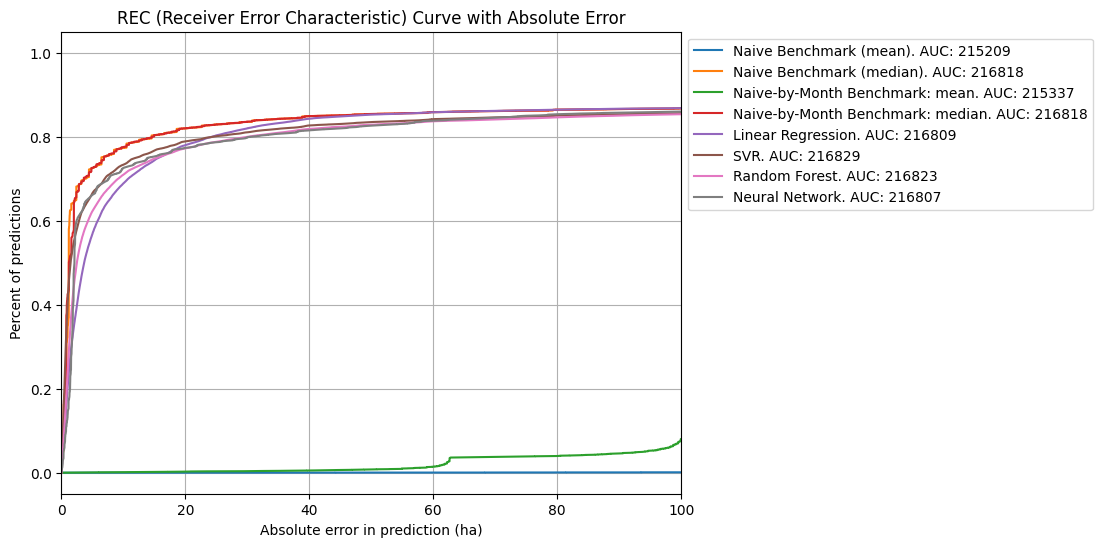

In [ ]:
# Plot
models = ["Naive Benchmark (mean)", "Naive Benchmark (median)", "Naive-by-Month Benchmark: mean", "Naive-by-Month Benchmark: median", \
          "Linear Regression", "SVR", "Random Forest", "Neural Network"]

train_indices = y_train.index

y_preds = [y_mean[train_indices], y_median[train_indices], y_mean_by_month[train_indices], y_median_by_month[train_indices], \
           y_preds_lr, y_preds_svr, y_preds_rf, y_pred_nn]
plot_rec_curve(models, y_train, y_preds, max_error = 100)

#### Comments on the plot above
This plot turned out not to be especially helpful in comparing the models. The reason is the strong skew of the data. The vast majority of fires are less than a few hectares in size. As long as a model predict fires to be less than, say, 50 hectares in size, they will be less than 50 hectares wrong for the vast majority of fires. (Note that the x-axis on the plot above has been truncated; it actually goes up to over 200,000, which is the largest absolute prediction error.)

We need some other metric to compare the models.

Looking at the error measured in absolute hectares might not be what's most relevant. If we predict a fire to be 10,000 hectares in size, and it turns out to be 10,100 hectares, then that should be considered an excellent prediction. But if we predict a fire to be 5 hectares, and it turns out to be 105, then that should be considered a poor prediction.

So rather than looking at how off a prediction is in absolute numbers, we will look at how off it is percentagewise. We'll adjust the REC curve so that the torelance (shown on the x-axis) is the percentagewise error.




### Percentagewise REC Curve

In [ ]:
def plot_rec_curve_percentage(models, y_true, y_preds, max_error=None):
    """
    Plots the Receiver Error Characteristic (REC) curve using percentage errors.
    The REC curve visualizes the cumulative distribution of percentage prediction
    errors, providing insights into model performance.

    Parameters:
    ----------
    models : list of str
        A list of model names corresponding to the predictions provided in `y_preds`.
    y_true : numpy.ndarray or pandas.Series
        The true target values.
    y_preds : list of numpy.ndarray or pandas.Series
        A list of predicted values, where each element corresponds to predictions
        made by one of the models in `models`.
    max_error : float, optional (default=None)
        The maximum percentage error to display on the x-axis. If `None`, the x-axis
        will scale automatically to the range of the percentage errors.

    Returns:
    -------
    None
        Displays the REC curve plot. Does not return any object.

    Notes:
    -----
    - The percentage error is calculated as:
        `percentage_error = 100 * |y_true - y_pred| / max(y_true, 1e-6)`
      where a small epsilon (1e-6) is added to prevent division by zero.
    - The REC curve plots the percentage errors against the cumulative proportion
      of predictions, providing an aggregated measure of error distribution.
    - The Area Under the REC Curve (AUC-REC) is calculated using the trapezoidal rule
      and displayed in the legend for each model.
    """

    plt.figure(figsize=(8, 6))

    for model, y_pred in zip(models, y_preds):
        percentage_errors = 100 * np.abs(y_true - y_pred) / np.maximum(y_true, 1e-6)

        sorted_errors = np.sort(percentage_errors)

        # Calculate cumulative proportions
        cumulative_proportion = np.linspace(0, 100, len(sorted_errors))

        # Calculate AUC-REC using the trapezoidal rule
        auc_rec = np.trapz(cumulative_proportion, x=sorted_errors)

        # Plot the REC curve
        plt.plot(sorted_errors, cumulative_proportion, label=f"{model}. AUC: {auc_rec.astype(int)}")

    plt.xlabel("Percentage error in prediction (%)")
    plt.ylabel("Percent of predictions")
    plt.title("REC (Receiver Error Characteristic) Curve with Percentage Error")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)

    # Apply max_error only to set x-axis limit
    if max_error is not None:
        plt.xlim(0, max_error)

    plt.show

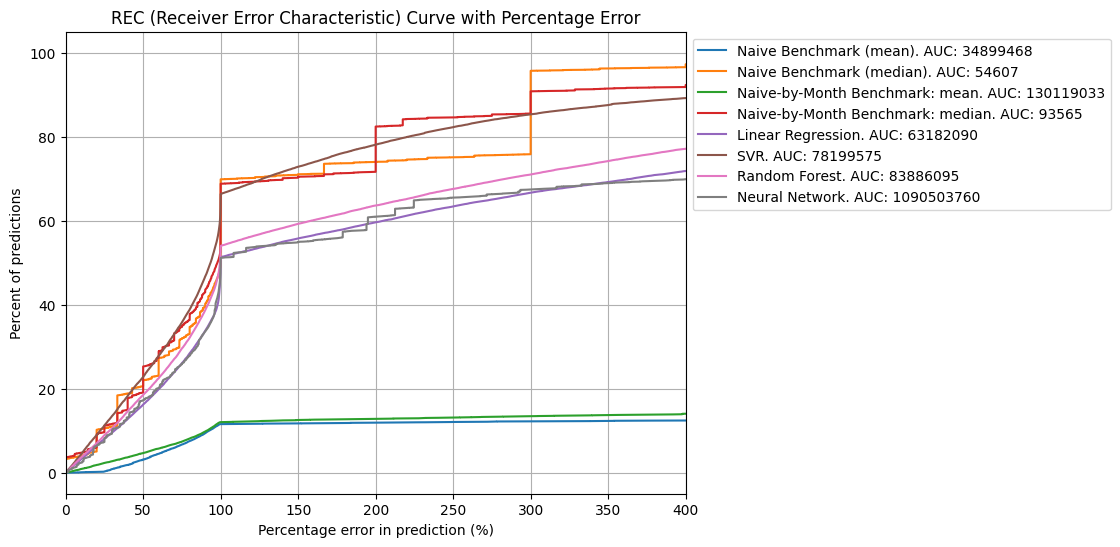

In [ ]:
# Plot
models = ["Naive Benchmark (mean)", "Naive Benchmark (median)", "Naive-by-Month Benchmark: mean", "Naive-by-Month Benchmark: median", \
          "Linear Regression", "SVR", "Random Forest", "Neural Network"]
y_preds = [y_mean[train_indices], y_median[train_indices], y_mean_by_month[train_indices], y_median_by_month[train_indices], \
           y_preds_lr, y_preds_svr, y_preds_rf, y_pred_nn]
plot_rec_curve_percentage(models, y_train, y_preds, max_error = 400)

#### Comments on the plot above

The best model, based on the plot above, seems to be the SVR (brown line), and the best-performing benchmarks the median-based ones. To increase legibility, we'll output just these three lines in a new plot.

### Percentagewise REC Curve for SVR and the median-based benchmarks

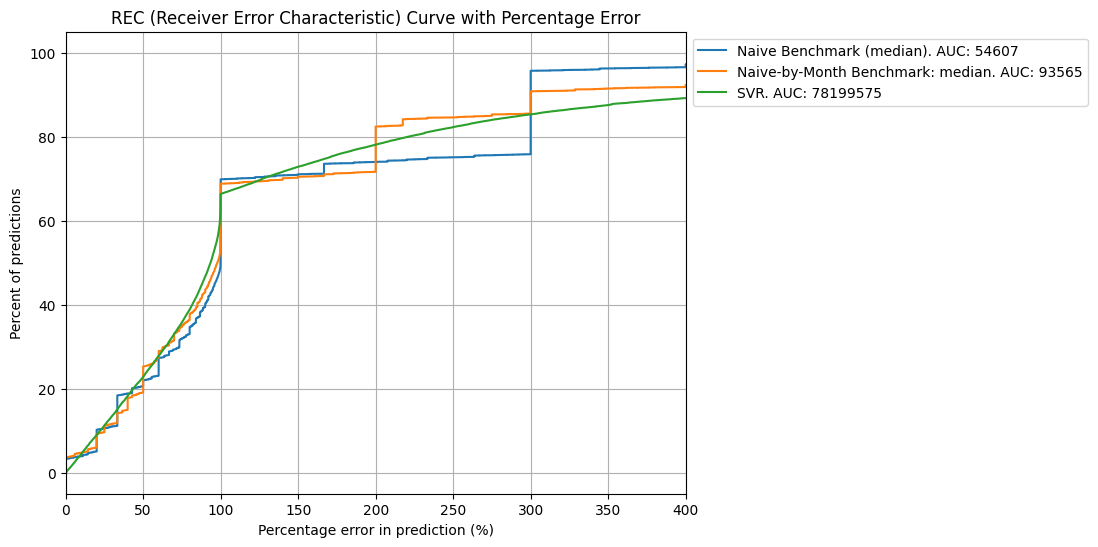

In [ ]:
# Plot
models = ["Naive Benchmark (median)", "Naive-by-Month Benchmark: median", "SVR"]
y_preds = [y_median[train_indices], y_median_by_month[train_indices], y_preds_svr]
plot_rec_curve_percentage(models, y_train, y_preds, max_error = 400)

#### Comments on the plot above

The results are rather disappointing. Measured like this, on the percentagewise error in the prediction, our best model, the SVR model, performs very similar to the median-based benchmarks.







# **Evalute the Best Model on the Test Set**

Based on the REC curves above, I choose SVR as the best model, even though it wasn't the best on any of the three metrics MAE, RMSE, or MAPE. I will now evaluate it on the test data, and compare it with the benchmarks.

## **MAE, RMSE, and MAPE**

The Mean Absolute Perentagewise Error (which I think is the most relevant of these three metrics for this data) looks excellent if we compare it to the mean-based benchmarks – but horrible when compared to the median-based benchmarks.



In [ ]:
%%time
# Naive and naive-by-month benchmark
final_results_df = benchmark_df.copy()

# Retrain the SVR model on the entire training set
svr_wrapper.fit_model_on_entire_training_set(X_train_scaled, y_train)

# Evaluate the SVR model on the test set
mae, rmse, mape = svr_wrapper.evaluate_model_on_test_set(X_test_scaled, y_test)

# Add the results to the table
new_row = pd.DataFrame([{
    'Model': 'SVR',
    'MAE': f"{mae:.2f}",
    'RMSE': f"{rmse:.2f}",
    'MAPE': f"{mape:.2f}"
}])

final_results_df = pd.concat([final_results_df, new_row], ignore_index = True)

final_results_df

CPU times: user 1min 8s, sys: 115 ms, total: 1min 8s
Wall time: 1min 8s


,Model,MAE,RMSE,MAPE
0,Naive benchmark (mean-based),1610.60,6142.47,956.55
1,Naive-by-month benchmark (mean-based),1465.86,6069.49,873.56
2,Naive benchmark (median-based),917.48,6210.47,1.38
3,Naive-by-month benchmark (median-based),917.45,6210.39,1.41
4,SVR,872.38,5677.91,10.09


## **REC curve based on the test data**

The plot below looks very similar to what we saw for the cross-validation data (which is expected). The results, again, are disappointing.

In [ ]:
%%time
# Make predictions
y_test_preds_svr = np.exp(svr_wrapper.model.predict(X_test_scaled)) # Exponentiate to convert to original scale.

CPU times: user 14.5 s, sys: 3.59 ms, total: 14.5 s
Wall time: 14.4 s


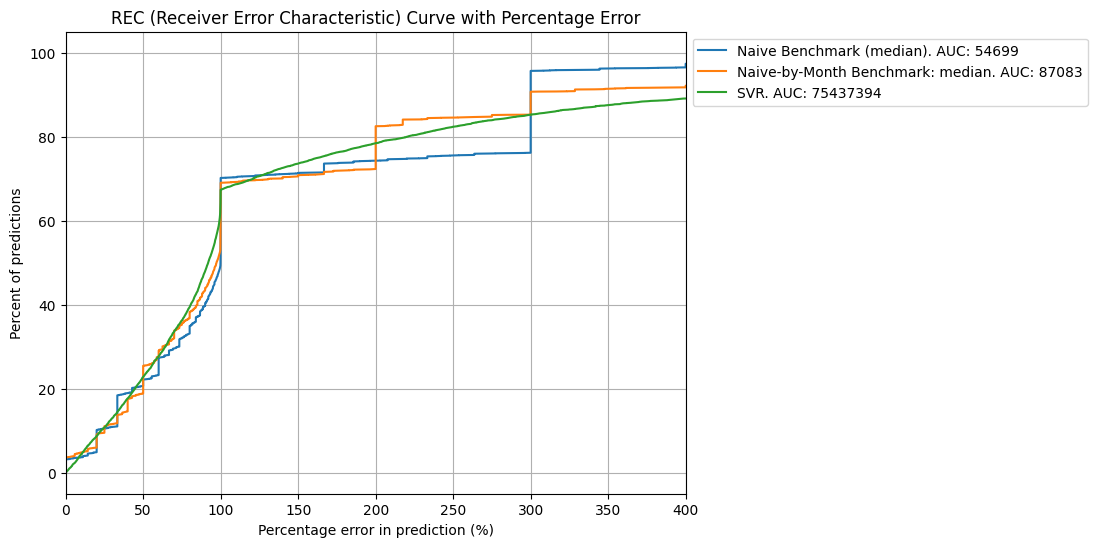

In [ ]:
# Plot
models = ["Naive Benchmark (median)", "Naive-by-Month Benchmark: median", "SVR"]

test_indices = y_test.index

y_preds = [y_median[test_indices], y_median_by_month[test_indices], y_test_preds_svr]

plot_rec_curve_percentage(models, y_test, y_preds, max_error = 400) # Pass y_test and y_preds in the original scale

## **Another way to look at the results ...**

I add this section just to show how easily you can make bad results look good.

Below, I split the data into deciles based on the fire size. For each decile, I compute how wrong the model's predictions are, percentagewise. The resulting bar chart shows us how good the model is for predicting the smallest 10% of the fires, the largest 10% of the fires, and all the deciles in between.


In [ ]:
def plot_mean_percentage_errors_by_decile(y_true, model_preds, benchmark_preds, labels):
    """
    Generates a bar chart comparing the mean percentage prediction error for each decile
    of the test set, for model predictions and benchmark predictions.

    Parameters:
    ----------
    y_true : numpy.ndarray or pandas.Series
        The true target values.
    model_preds : numpy.ndarray or pandas.Series
        The predicted values from the model being evaluated.
    benchmark_preds : numpy.ndarray or pandas.Series
        The predicted values from the benchmark model for comparison.
    labels : list of str
        A list containing two strings: the label for the model predictions and the
        label for the benchmark predictions, used in the chart legend.

    Returns:
    -------
    None
        Displays a bar chart comparing mean percentage prediction errors for each decile.

    Notes:
    -----
    - The function first divides the data into 10 deciles based on ascending order of `y_true`.
    - Mean percentage prediction error is calculated as:
        `100 * |y_true - y_pred| / max(y_true, 1e-6)`
      where a small epsilon (1e-6) is added to prevent division by zero.
    - The chart provides a side-by-side comparison of errors for the two models in each decile.
    """

    # Create a DataFrame for easy manipulation
    df = pd.DataFrame({
        'y_true': y_true,
        'model_preds': model_preds,
        'benchmark_preds': benchmark_preds
    })

    # Order by the true response variable in ascending order
    df = df.sort_values(by='y_true').reset_index(drop=True)

    # Split into 10 deciles
    deciles = np.array_split(df, 10)

    # Calculate mean percentage errors for each decile
    model_mean_errors = []
    benchmark_mean_errors = []
    for decile in deciles:
        # Prevent division by zero by using np.maximum
        true_values = decile['y_true']
        model_errors = 100 * np.abs(true_values - decile['model_preds']) / np.maximum(true_values, 1e-6)
        benchmark_errors = 100 * np.abs(true_values - decile['benchmark_preds']) / np.maximum(true_values, 1e-6)
        model_mean_errors.append(model_errors.mean())
        benchmark_mean_errors.append(benchmark_errors.mean())

    # Generate bar chart
    x = np.arange(1, 11)  # X-axis positions for 10 deciles
    width = 0.35  # Width of the bars

    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, model_mean_errors, width, label=labels[0], color='blue')
    plt.bar(x + width/2, benchmark_mean_errors, width, label=labels[1], color='orange')

    plt.xlabel('Decile (Ordered by Fire Size)')
    plt.ylabel('Mean Percentage Error (%)')
    plt.title('Mean Percentage Prediction Error by Fire Size')
    plt.xticks(x, labels=[f'Decile {i}' for i in range(1, 11)])
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


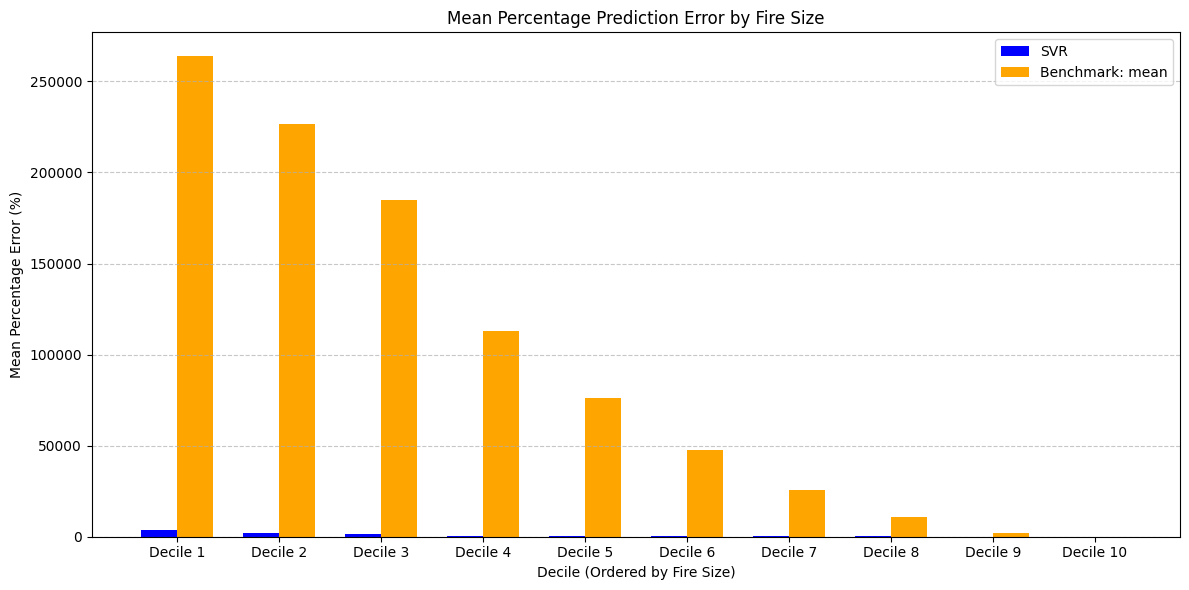

In [ ]:
# Plot
plot_mean_percentage_errors_by_decile(y_test,
                                      y_test_preds_svr,
                                      y_mean[y_test.index],
                                      ['SVR', 'Benchmark: mean'])

#### Comments on the plot above

The results look excellent! The blue bars show that the model has a very small percentagewise error, compared with the giant errors for the naive benchmark.

But this is the mean-based benchmark, which turned out to be the easier one to beat. Now, let's compare our model to the median-based benchmark.

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


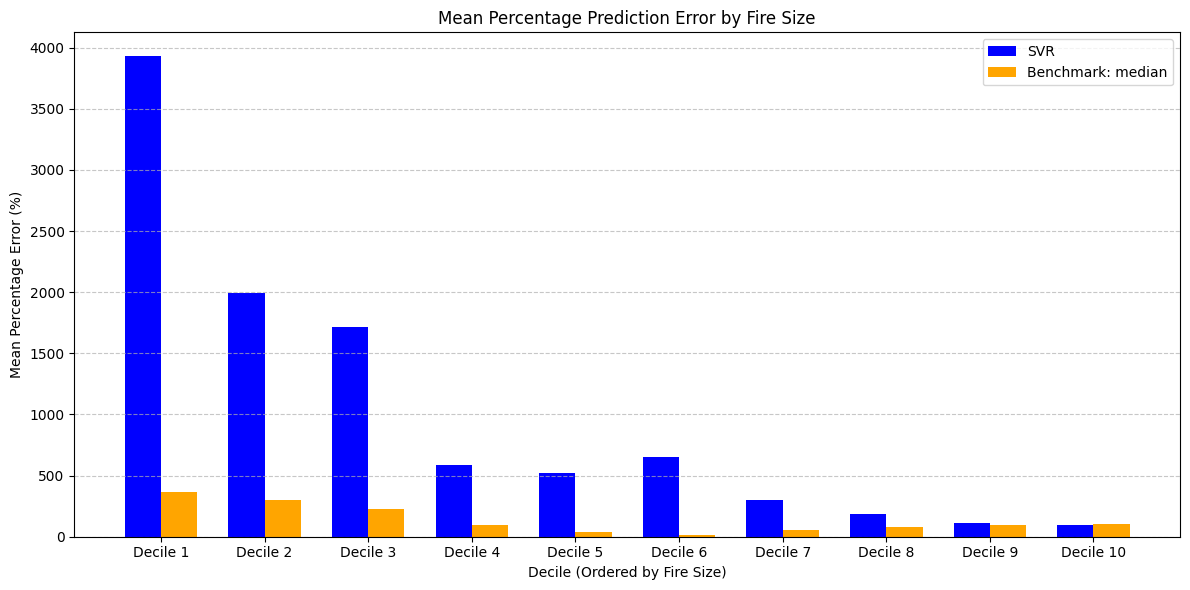

In [ ]:
# Plot
plot_mean_percentage_errors_by_decile(y_test,
                                      y_test_preds_svr,
                                      y_median[y_test.index],
                                      ['SVR', 'Benchmark: median'])

#### Comments on the plot above
Here, our model looks lousy. The model's blue bars exhibit a much larger percentagewise error than the yellow bars for the median-based benchmark.



# **Discussion and Conclusion**

The goal of this project was to see if a machine-learning model can be used to predict the size of wildfires in the U.S. based on metereological data and vegetation type.

The metrics used for evaluting the models were Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE).

Benchmarks were created using both the mean and the median fire size as naive predictions.

Due to the extreme skew of the response variable (the size of the fires), it was log-transformed for the training of the models, which means that the model predictions were also in log scale. These predictions were transformed back to the original scale before calculating the performance metrics.

The results were rather disappointing. While some of the models beat the naive benchmarks for some metrics, none of the models came even close to beating the median-based benchmark for the metric which I think is most relevant for this data, namely the MAPE.

The difficulty in beating the naive median-based benchmark has to do with the extreme skew of the data. A majority of the fires are very small. (Almost 70% are smaller than 5 hectares.)

This means that if we had a model that for any fire, regardless of the predictors, just guessed "I'm sure it will be very small!", then that model would usually be right. And that is basically what the median-based benchmarks do.

# **Ideas for Future Work**
It's hard to believe that some meteorological factors, especially the amount of precipitation in the week or month leading up to a wildfire, wouldn't have some impact on how large the fire turns out to be, and yet I haven't been able to develop a model that can beat a naive median-base benchmark. Perhaps there are other factors, not included in these models, that have an even larger impact than the meteorological factors, and that whatever relationships I've modeled drown in these unmodeled effects.

For future work, one might try to find such factors. Some possibilities are:
* The location of the fire. Perhaps fires tend to be larger in some parts of the U.S. than in others, or perhaps the distance to the closest urban area (providing more fire-fighting resources) affects the size of fires.
* The size of the fire when it's discovered. It seems likely that fires that have reached a larger size before they are discovered turn out to be larger in total than those who are discovered while they are still small.


